# The ElasticNet interpretations (for the most abundant cell types)

## Outline

The **MLAging Cell-type** workflow consists of four sections:

I. Data Preprocessing in Seurat ```preprocessing.R```

II. ElasticNet Tuning (hyperparameter selection for  with ```GridSearchCV```): 

1. [Data Preparation](#1.-prep)
2. [Cell Types](#2.-celltypes)
    - [Neuron](#3.-neuron)
    - [Oligodendrycte](#4.-Oligo)
    - [Astrocyte](#5.-astro)
    - [Microglia](#6.-micro)

III. Final Models Over 10 Random States

IV. Results and Intepretations -- **this notebook**:

## 1. Thorough evaluation of the best model<a name="5.-eval"></a>
### a) Normalized cofusion matrix<a name="6.-cm"></a>

In [15]:
import sys
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import matplotlib as mpl
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import tqdm
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from operator import itemgetter

from sklearn.metrics import precision_recall_curve, auc

In [2]:
file = open('../results/cell_type_best/Microglia_eln_model_test_models.save', 'rb')
final_models = pickle.load(file)
file.close()

file = open('../results/cell_type_best/Microglia_eln_model_test_sets.save', 'rb')
final_data = pickle.load(file)
file.close()

In [3]:
X = final_data[0][0]

In [76]:
def coefs_list_10(final_data, final_models):
    coefs_list = []
    for i in range(len(final_data)):
        X_test, y_test = final_data[i]
        clf = final_models[i]
    
        y_test_pred = clf.predict(X_test)
        y_test_prob = clf.predict_proba(X_test)
    
        coefs = clf.coef_
        coefs_list.append(coefs)
        
    coefs_list_1 = np.array([a[0] for a in coefs_list])
    mean_coefs = np.mean(coefs_list_1,axis=0)
    std_coefs = np.std(coefs_list_1,axis=0)
    return mean_coefs, std_coefs

In [168]:
cell_types = ['Neuron', 'Oligodendrocyte', 'Astrocyte', 'OPC', 'Microglia']
for i in cell_types:
    file = open('../results/cell_type_best/'+ i + '_eln_model_test_models.save', 'rb')
    final_models = pickle.load(file)
    file.close()
    
    file = open('../results/cell_type_best/' + i + '_eln_model_test_sets.save', 'rb')
    final_data  = pickle.load(file)
    file.close() 
    
    locals()[i] = coefs_list_10(final_data, final_models)

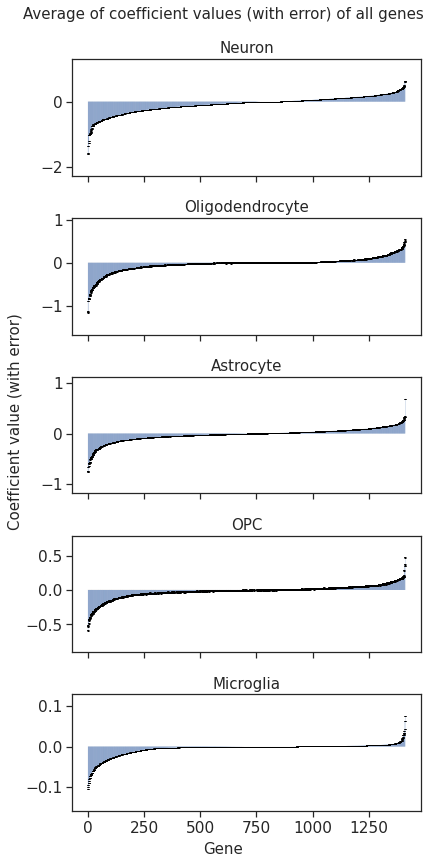

In [130]:
fig, axs  = plt.subplots(5,1, figsize=(6,12), sharex=True)
sns.set(font_scale=1.4, style='ticks')

for i in cell_types:
    mean_coefs, std_coefs = locals()[i]
    number = cell_types.index(i)
    axs[number].bar(np.arange(1413), np.sort(mean_coefs), yerr=std_coefs, snap=False, capsize=1,
        color=sns.color_palette()[0], 
        edgecolor=sns.color_palette()[0],
        linewidth=0.005,
        ecolor='black')
    
    axs[number].set_title(f'{i}', fontsize=15)
    axs[number].set_ylim(min(mean_coefs)-0.3*(max(mean_coefs)-min(mean_coefs)), 
                         max(mean_coefs)+0.3*(max(mean_coefs)-min(mean_coefs)))

fig.text(0.5, 0.0, 'Gene', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Coefficient value (with error)', va='center', rotation='vertical', fontsize=15)
fig.suptitle('Average of coefficient values (with error) of all genes', fontsize=15)

plt.tight_layout()
plt.savefig('../figures/4d_celltype_waterfall.pdf')

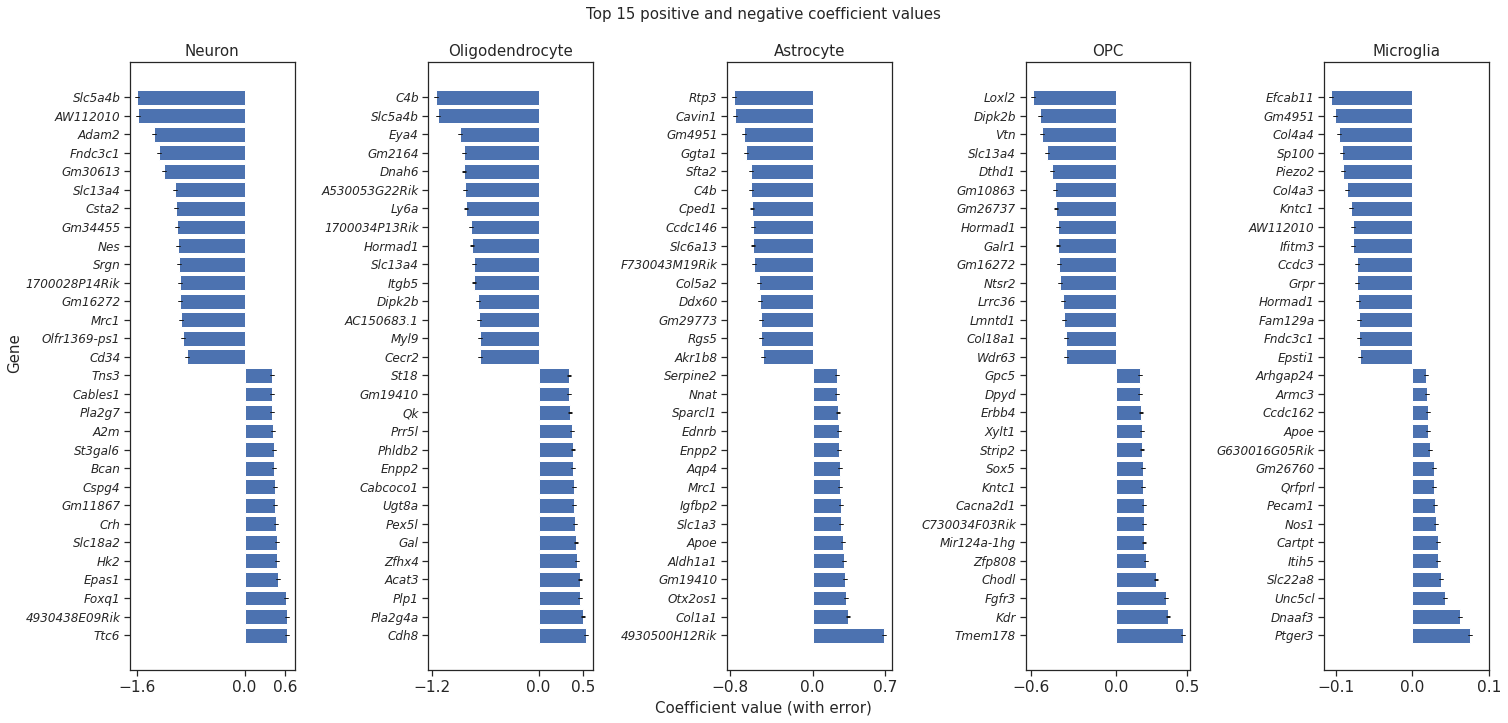

In [129]:
fig, axs  = plt.subplots(1,5, figsize=(21,10))
sns.set(font_scale=1.4, style='ticks')

for i in cell_types:
    mean_coefs, std_coefs = locals()[i]
    abs_thetas_tuple = [(i,coef) for i,coef in enumerate(mean_coefs)]
    results = sorted(abs_thetas_tuple, key=itemgetter(1), reverse=True)

    nr_coefs = 30
    
    top_coefs_result = [(result, X.columns[result[0]]) for result in results][:15]
    top_coefs_result = top_coefs_result + [(result, X.columns[result[0]]) for result in results][-15:]
    top_coefs = [mean_coefs[t[0][0]] for t in top_coefs_result]
    top_features = [t[1] for t in top_coefs_result]
    std_top_coefs = [std_coefs[t[0][0]] for t in top_coefs_result]

    number = cell_types.index(i)
    axs[number].barh(np.arange(nr_coefs), top_coefs, yerr=std_top_coefs, capsize=2)
    axs[number].set_yticks(np.arange(nr_coefs))
    axs[number].set_yticklabels(top_features, style='italic', fontsize=12)
    
    axs[number].set_xticks((round(min(top_coefs), 1), 0, round(max(top_coefs), 1)))

    axs[number].set_title(f'{i}', fontsize=15)

fig.text(0.5, 0.0, 'Coefficient value (with error)', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Gene', va='center', rotation='vertical', fontsize=15)
fig.suptitle('Top 15 positive and negative coefficient values', fontsize=15)
plt.tight_layout()
plt.savefig('../figures/4e_celltype_top_waterfall.pdf')

In [143]:
def abs_coefs_list(mean_coefs):
    abs_coefs = np.absolute(mean_coefs)
    abs_thetas_tuple = [(i,coef) for i,coef in enumerate(abs_coefs)]
    results_abs = sorted(abs_thetas_tuple, key=itemgetter(1), reverse=True)
    print(pd.value_counts(abs_coefs == 0))
    ranked_list = [X.columns[result[0]] for result in results_abs]
    return ranked_list

In [178]:
score_list = []
ftr_names_list = []
for i in cell_types:
    file = open('../results/cell_type_best/'+ i + '_eln_model_test_models.save', 'rb')
    final_models = pickle.load(file)
    file.close()
    
    file = open('../results/cell_type_best/' + i + '_eln_model_test_sets.save', 'rb')
    final_data  = pickle.load(file)
    file.close() 
    
    X_test, y_test = final_data[0]
    grid = final_models[0]
    
    X_test_shuffled = X_test.copy()
    
    mean_coefs, std_coefs = locals()[i]
    
    ftr_names = abs_coefs_list(mean_coefs)
    ftr_names.reverse()
    nr_runs = 10
    scores = np.zeros([len(ftr_names), nr_runs])
    
    for i in range(len(ftr_names)):
        print('shuffling '+ str(ftr_names[i]))
        auprc_scores = []
        for j in range(nr_runs):
            X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_shuffled[ftr_names[i]].values)
            y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
            precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
            auprc_scores.append(auc(recall, precision))
        print('shuffled test score:', np.around(np.mean(auprc_scores),4),'+/-', np.around(np.std(auprc_scores),4))
        scores[i] = auprc_scores
    score_list.append(scores)
    ftr_names_list.append(ftr_names)

False    1349
True       64
dtype: int64
shuffling Ddah1
shuffled test score: 0.9667 +/- 0.0
shuffling Slc25a13
shuffled test score: 0.9667 +/- 0.0
shuffling Mro
shuffled test score: 0.9667 +/- 0.0
shuffling Ccdc60
shuffled test score: 0.9667 +/- 0.0
shuffling Zfp36l1
shuffled test score: 0.9667 +/- 0.0
shuffling Slc13a1
shuffled test score: 0.9667 +/- 0.0
shuffling Dgkg
shuffled test score: 0.9667 +/- 0.0
shuffling Tgfb2
shuffled test score: 0.9667 +/- 0.0
shuffling Brinp2
shuffled test score: 0.9667 +/- 0.0
shuffling Tril
shuffled test score: 0.9667 +/- 0.0
shuffling Slc2a1
shuffled test score: 0.9667 +/- 0.0
shuffling Nckap1l
shuffled test score: 0.9667 +/- 0.0
shuffling Cnih3
shuffled test score: 0.9667 +/- 0.0
shuffling Hmcn2
shuffled test score: 0.9667 +/- 0.0
shuffling Ret
shuffled test score: 0.9667 +/- 0.0
shuffling Ar
shuffled test score: 0.9667 +/- 0.0
shuffling Gli3
shuffled test score: 0.9667 +/- 0.0
shuffling Has2os
shuffled test score: 0.9667 +/- 0.0
shuffling Nos1
shuff

shuffled test score: 0.9668 +/- 0.0
shuffling Alk
shuffled test score: 0.9668 +/- 0.0
shuffling Nek11
shuffled test score: 0.9668 +/- 0.0
shuffling Wwc1
shuffled test score: 0.9668 +/- 0.0
shuffling Syt10
shuffled test score: 0.9668 +/- 0.0
shuffling Zbbx
shuffled test score: 0.9668 +/- 0.0
shuffling Auts2
shuffled test score: 0.9668 +/- 0.0
shuffling Kcnb2
shuffled test score: 0.9668 +/- 0.0
shuffling Kcnt2
shuffled test score: 0.9668 +/- 0.0
shuffling Man2a1
shuffled test score: 0.9668 +/- 0.0
shuffling Slc25a21
shuffled test score: 0.9668 +/- 0.0
shuffling Lmx1a
shuffled test score: 0.9668 +/- 0.0
shuffling Lgr5
shuffled test score: 0.9668 +/- 0.0
shuffling Nin
shuffled test score: 0.9668 +/- 0.0
shuffling Pvt1
shuffled test score: 0.9668 +/- 0.0
shuffling Ecel1
shuffled test score: 0.9668 +/- 0.0
shuffling Fam189a1
shuffled test score: 0.9668 +/- 0.0
shuffling C030029H02Rik
shuffled test score: 0.9668 +/- 0.0
shuffling Sdk2
shuffled test score: 0.9668 +/- 0.0
shuffling Pde1a
shuffl

shuffled test score: 0.9665 +/- 0.0
shuffling C1ql1
shuffled test score: 0.9666 +/- 0.0
shuffling Nrxn3
shuffled test score: 0.9666 +/- 0.0
shuffling Schip1
shuffled test score: 0.9665 +/- 0.0
shuffling Epha10
shuffled test score: 0.9665 +/- 0.0
shuffling Zswim6
shuffled test score: 0.9665 +/- 0.0
shuffling Frmpd4
shuffled test score: 0.9666 +/- 0.0
shuffling Mthfd1l
shuffled test score: 0.9666 +/- 0.0
shuffling Gm5149
shuffled test score: 0.9666 +/- 0.0
shuffling Spats2l
shuffled test score: 0.9666 +/- 0.0
shuffling Prkg1
shuffled test score: 0.9666 +/- 0.0
shuffling Gpc4
shuffled test score: 0.9666 +/- 0.0
shuffling Scn5a
shuffled test score: 0.9666 +/- 0.0
shuffling Vwa3a
shuffled test score: 0.9666 +/- 0.0
shuffling Slc1a2
shuffled test score: 0.9666 +/- 0.0
shuffling A330102I10Rik
shuffled test score: 0.9666 +/- 0.0
shuffling Fam216b
shuffled test score: 0.9666 +/- 0.0
shuffling Cdh19
shuffled test score: 0.9666 +/- 0.0
shuffling Cdh12
shuffled test score: 0.9666 +/- 0.0
shuffling

shuffled test score: 0.9665 +/- 0.0
shuffling Hlf
shuffled test score: 0.9665 +/- 0.0
shuffling Fmod
shuffled test score: 0.9664 +/- 0.0
shuffling Sorcs3
shuffled test score: 0.9664 +/- 0.0
shuffling Ccdc114
shuffled test score: 0.9664 +/- 0.0
shuffling Atrnl1
shuffled test score: 0.9664 +/- 0.0
shuffling Sema5a
shuffled test score: 0.9664 +/- 0.0
shuffling Sparc
shuffled test score: 0.9664 +/- 0.0
shuffling Agt
shuffled test score: 0.9665 +/- 0.0
shuffling Plcl1
shuffled test score: 0.9665 +/- 0.0
shuffling Lrrc7
shuffled test score: 0.9664 +/- 0.0
shuffling Kcnh7
shuffled test score: 0.9664 +/- 0.0
shuffling Zfp423
shuffled test score: 0.9664 +/- 0.0
shuffling Syt6
shuffled test score: 0.9664 +/- 0.0
shuffling Camk4
shuffled test score: 0.9664 +/- 0.0
shuffling Gm10714
shuffled test score: 0.9664 +/- 0.0
shuffling Tmem196
shuffled test score: 0.9664 +/- 0.0
shuffling Dipk2b
shuffled test score: 0.9665 +/- 0.0
shuffling Sel1l3
shuffled test score: 0.9665 +/- 0.0
shuffling Strip2
shuff

shuffled test score: 0.9659 +/- 0.0
shuffling Epha6
shuffled test score: 0.9659 +/- 0.0
shuffling Gab1
shuffled test score: 0.9659 +/- 0.0
shuffling Col4a5
shuffled test score: 0.9659 +/- 0.0
shuffling Ntn1
shuffled test score: 0.9658 +/- 0.0
shuffling Asb4
shuffled test score: 0.9659 +/- 0.0
shuffling Phactr1
shuffled test score: 0.966 +/- 0.0
shuffling Cpne7
shuffled test score: 0.9659 +/- 0.0
shuffling Vwc2l
shuffled test score: 0.9659 +/- 0.0
shuffling Nox4
shuffled test score: 0.9659 +/- 0.0
shuffling Grm1
shuffled test score: 0.9659 +/- 0.0
shuffling Patj
shuffled test score: 0.9659 +/- 0.0
shuffling Cpne5
shuffled test score: 0.9659 +/- 0.0
shuffling Nfia
shuffled test score: 0.9658 +/- 0.0
shuffling Cdkl5
shuffled test score: 0.9659 +/- 0.0
shuffling Etv1
shuffled test score: 0.9659 +/- 0.0
shuffling Ildr2
shuffled test score: 0.9659 +/- 0.0
shuffling 6430628N08Rik
shuffled test score: 0.9659 +/- 0.0
shuffling Ptpn3
shuffled test score: 0.9659 +/- 0.0
shuffling Khdrbs3
shuffled

shuffled test score: 0.9657 +/- 0.0
shuffling Ebf2
shuffled test score: 0.9658 +/- 0.0
shuffling Vcan
shuffled test score: 0.9658 +/- 0.0
shuffling T2
shuffled test score: 0.9657 +/- 0.0
shuffling Slc1a3
shuffled test score: 0.9658 +/- 0.0
shuffling Ldb2
shuffled test score: 0.9657 +/- 0.0
shuffling Dbx2
shuffled test score: 0.9657 +/- 0.0
shuffling Tmem200a
shuffled test score: 0.9656 +/- 0.0
shuffling Gm45341
shuffled test score: 0.9656 +/- 0.0
shuffling Lrig1
shuffled test score: 0.9656 +/- 0.0
shuffling Adap2os
shuffled test score: 0.9656 +/- 0.0
shuffling Tmtc2
shuffled test score: 0.9656 +/- 0.0
shuffling Ghrh
shuffled test score: 0.9655 +/- 0.0
shuffling Cntn5
shuffled test score: 0.9653 +/- 0.0
shuffling Vat1l
shuffled test score: 0.9653 +/- 0.0
shuffling Spink10
shuffled test score: 0.9653 +/- 0.0
shuffling Lzts1
shuffled test score: 0.9652 +/- 0.0
shuffling Casp8
shuffled test score: 0.9652 +/- 0.0
shuffling Myl9
shuffled test score: 0.9651 +/- 0.0
shuffling Pard3b
shuffled t

shuffled test score: 0.9627 +/- 0.0
shuffling Kntc1
shuffled test score: 0.9622 +/- 0.0
shuffling Adcy2
shuffled test score: 0.9621 +/- 0.0
shuffling Khdrbs2
shuffled test score: 0.9618 +/- 0.0
shuffling Syt2
shuffled test score: 0.9619 +/- 0.0
shuffling Zmat4
shuffled test score: 0.9619 +/- 0.0
shuffling Pecam1
shuffled test score: 0.9617 +/- 0.0
shuffling Ebf1
shuffled test score: 0.9617 +/- 0.0
shuffling Csf3r
shuffled test score: 0.9616 +/- 0.0
shuffling Adamts12
shuffled test score: 0.9616 +/- 0.0
shuffling Jam2
shuffled test score: 0.9617 +/- 0.0
shuffling Igfbp7
shuffled test score: 0.9616 +/- 0.0
shuffling Csf1r
shuffled test score: 0.9617 +/- 0.0
shuffling Scn7a
shuffled test score: 0.9616 +/- 0.0
shuffling Kcnc2
shuffled test score: 0.9614 +/- 0.0
shuffling Neto1
shuffled test score: 0.9613 +/- 0.0
shuffling Cntnap4
shuffled test score: 0.9612 +/- 0.0
shuffling Grm8
shuffled test score: 0.961 +/- 0.0
shuffling Tgfbr1
shuffled test score: 0.961 +/- 0.0
shuffling Nrp2
shuffled 

shuffled test score: 0.96 +/- 0.0
shuffling Slc26a7
shuffled test score: 0.9599 +/- 0.0
shuffling Otx2os1
shuffled test score: 0.9598 +/- 0.0
shuffling Nostrin
shuffled test score: 0.9597 +/- 0.0
shuffling Gm12027
shuffled test score: 0.9597 +/- 0.0
shuffling Dgkk
shuffled test score: 0.9598 +/- 0.0
shuffling Mamdc2
shuffled test score: 0.9597 +/- 0.0
shuffling Rbfox1
shuffled test score: 0.96 +/- 0.0
shuffling Kcnmb2
shuffled test score: 0.9602 +/- 0.0
shuffling Sox5os4
shuffled test score: 0.9603 +/- 0.0
shuffling Unc13b
shuffled test score: 0.9602 +/- 0.0
shuffling Ttc29
shuffled test score: 0.9603 +/- 0.0
shuffling Thsd4
shuffled test score: 0.9604 +/- 0.0
shuffling Gm29865
shuffled test score: 0.9605 +/- 0.0
shuffling Siglech
shuffled test score: 0.9605 +/- 0.0
shuffling Cd38
shuffled test score: 0.9604 +/- 0.0
shuffling Gm6145
shuffled test score: 0.9604 +/- 0.0
shuffling Ror1
shuffled test score: 0.9605 +/- 0.0
shuffling Itga9
shuffled test score: 0.9605 +/- 0.0
shuffling Clic4


shuffled test score: 0.9566 +/- 0.0001
shuffling Greb1l
shuffled test score: 0.9565 +/- 0.0
shuffling Gm39653
shuffled test score: 0.9563 +/- 0.0
shuffling Tbx19
shuffled test score: 0.956 +/- 0.0
shuffling Gm29773
shuffled test score: 0.9556 +/- 0.0
shuffling St8sia2
shuffled test score: 0.9558 +/- 0.0
shuffling Megf11
shuffled test score: 0.9558 +/- 0.0
shuffling Lgals9
shuffled test score: 0.9556 +/- 0.0
shuffling Acss1
shuffled test score: 0.9556 +/- 0.0
shuffling Tns3
shuffled test score: 0.9556 +/- 0.0
shuffling Gm34544
shuffled test score: 0.9555 +/- 0.0
shuffling Cables1
shuffled test score: 0.9555 +/- 0.0
shuffling Ramp3
shuffled test score: 0.9556 +/- 0.0
shuffling Fbxl13
shuffled test score: 0.9555 +/- 0.0
shuffling Nms
shuffled test score: 0.9556 +/- 0.0
shuffling Pla2g7
shuffled test score: 0.9555 +/- 0.0
shuffling Ak9
shuffled test score: 0.9554 +/- 0.0
shuffling C79798
shuffled test score: 0.9552 +/- 0.0
shuffling Acvrl1
shuffled test score: 0.9549 +/- 0.0
shuffling 1700

shuffled test score: 0.7953 +/- 0.0003
shuffling Cd34
shuffled test score: 0.7931 +/- 0.0002
shuffling Olfr1369-ps1
shuffled test score: 0.7868 +/- 0.0004
shuffling Mrc1
shuffled test score: 0.7862 +/- 0.0001
shuffling Gm16272
shuffled test score: 0.7758 +/- 0.0004
shuffling 1700028P14Rik
shuffled test score: 0.7681 +/- 0.0003
shuffling Srgn
shuffled test score: 0.7602 +/- 0.0003
shuffling Nes
shuffled test score: 0.7574 +/- 0.0002
shuffling Gm34455
shuffled test score: 0.7446 +/- 0.0006
shuffling Csta2
shuffled test score: 0.7331 +/- 0.0006
shuffling Slc13a4
shuffled test score: 0.729 +/- 0.0001
shuffling Gm30613
shuffled test score: 0.7189 +/- 0.0004
shuffling Fndc3c1
shuffled test score: 0.7162 +/- 0.0002
shuffling Adam2
shuffled test score: 0.6962 +/- 0.001
shuffling AW112010
shuffled test score: 0.6852 +/- 0.0004
shuffling Slc5a4b
shuffled test score: 0.6608 +/- 0.0008
False    1239
True      174
dtype: int64
shuffling Gm48727
shuffled test score: 0.9855 +/- 0.0
shuffling Fgd5
shu

shuffled test score: 0.9855 +/- 0.0
shuffling Gm14582
shuffled test score: 0.9855 +/- 0.0
shuffling Colec12
shuffled test score: 0.9855 +/- 0.0
shuffling Kcnh8
shuffled test score: 0.9855 +/- 0.0
shuffling Gm13481
shuffled test score: 0.9855 +/- 0.0
shuffling Gm49678
shuffled test score: 0.9855 +/- 0.0
shuffling Ccdc141
shuffled test score: 0.9855 +/- 0.0
shuffling Igf1
shuffled test score: 0.9855 +/- 0.0
shuffling A2m
shuffled test score: 0.9855 +/- 0.0
shuffling Dock8
shuffled test score: 0.9855 +/- 0.0
shuffling Gm26740
shuffled test score: 0.9855 +/- 0.0
shuffling Chst9
shuffled test score: 0.9855 +/- 0.0
shuffling Sfta3-ps
shuffled test score: 0.9855 +/- 0.0
shuffling Gm49171
shuffled test score: 0.9855 +/- 0.0
shuffling Gm6260
shuffled test score: 0.9855 +/- 0.0
shuffling Ankfn1
shuffled test score: 0.9855 +/- 0.0
shuffling Pappa2
shuffled test score: 0.9855 +/- 0.0
shuffling Siglech
shuffled test score: 0.9855 +/- 0.0
shuffling 9030622O22Rik
shuffled test score: 0.9855 +/- 0.0
s

shuffled test score: 0.9855 +/- 0.0
shuffling Thsd7b
shuffled test score: 0.9855 +/- 0.0
shuffling Grin3a
shuffled test score: 0.9855 +/- 0.0
shuffling Gm12296
shuffled test score: 0.9855 +/- 0.0
shuffling Hmcn2
shuffled test score: 0.9855 +/- 0.0
shuffling Cables1
shuffled test score: 0.9855 +/- 0.0
shuffling Gli3
shuffled test score: 0.9855 +/- 0.0
shuffling Bdnf
shuffled test score: 0.9855 +/- 0.0
shuffling Slit3
shuffled test score: 0.9855 +/- 0.0
shuffling 9630014M24Rik
shuffled test score: 0.9855 +/- 0.0
shuffling Antxr1
shuffled test score: 0.9855 +/- 0.0
shuffling Sgcd
shuffled test score: 0.9855 +/- 0.0
shuffling Gpc5
shuffled test score: 0.9855 +/- 0.0
shuffling Apod
shuffled test score: 0.9855 +/- 0.0
shuffling March4
shuffled test score: 0.9855 +/- 0.0
shuffling Ripor2
shuffled test score: 0.9855 +/- 0.0
shuffling Igfbp5
shuffled test score: 0.9855 +/- 0.0
shuffling Adgrl4
shuffled test score: 0.9855 +/- 0.0
shuffling Nwd2
shuffled test score: 0.9855 +/- 0.0
shuffling Itpkb

shuffled test score: 0.9855 +/- 0.0
shuffling Myo5b
shuffled test score: 0.9855 +/- 0.0
shuffling Rps6ka3
shuffled test score: 0.9855 +/- 0.0
shuffling Fstl5
shuffled test score: 0.9855 +/- 0.0
shuffling Spats2l
shuffled test score: 0.9855 +/- 0.0
shuffling Npas2
shuffled test score: 0.9855 +/- 0.0
shuffling Mcc
shuffled test score: 0.9855 +/- 0.0
shuffling Csgalnact1
shuffled test score: 0.9855 +/- 0.0
shuffling Cdh11
shuffled test score: 0.9855 +/- 0.0
shuffling Crh
shuffled test score: 0.9854 +/- 0.0
shuffling Nos1
shuffled test score: 0.9854 +/- 0.0
shuffling Bnc2
shuffled test score: 0.9854 +/- 0.0
shuffling Zbbx
shuffled test score: 0.9854 +/- 0.0
shuffling Ebf2
shuffled test score: 0.9854 +/- 0.0
shuffling Fras1
shuffled test score: 0.9854 +/- 0.0
shuffling Selenop
shuffled test score: 0.9854 +/- 0.0
shuffling Cdkl5
shuffled test score: 0.9854 +/- 0.0
shuffling Gm20713
shuffled test score: 0.9854 +/- 0.0
shuffling Dach1
shuffled test score: 0.9854 +/- 0.0
shuffling Mir9-3hg
shuf

shuffled test score: 0.9853 +/- 0.0
shuffling Sox10
shuffled test score: 0.9854 +/- 0.0
shuffling Ust
shuffled test score: 0.9854 +/- 0.0
shuffling Col18a1
shuffled test score: 0.9854 +/- 0.0
shuffling Dnah5
shuffled test score: 0.9854 +/- 0.0
shuffling Mro
shuffled test score: 0.9854 +/- 0.0
shuffling Slc17a6
shuffled test score: 0.9854 +/- 0.0
shuffling Zfp804a
shuffled test score: 0.9854 +/- 0.0
shuffling Cpa6
shuffled test score: 0.9854 +/- 0.0
shuffling Dcc
shuffled test score: 0.9854 +/- 0.0
shuffling Fstl4
shuffled test score: 0.9854 +/- 0.0
shuffling Acss1
shuffled test score: 0.9854 +/- 0.0
shuffling Gm2824
shuffled test score: 0.9854 +/- 0.0
shuffling 4930467D21Rik
shuffled test score: 0.9854 +/- 0.0
shuffling Galntl6
shuffled test score: 0.9854 +/- 0.0
shuffling Rnf152
shuffled test score: 0.9854 +/- 0.0
shuffling Sulf1
shuffled test score: 0.9854 +/- 0.0
shuffling Tlr7
shuffled test score: 0.9853 +/- 0.0
shuffling Chn2
shuffled test score: 0.9854 +/- 0.0
shuffling A330008L1

shuffled test score: 0.9853 +/- 0.0
shuffling Lhx1os
shuffled test score: 0.9852 +/- 0.0
shuffling Kcnip1
shuffled test score: 0.9852 +/- 0.0
shuffling Trpc3
shuffled test score: 0.9852 +/- 0.0
shuffling Cfap54
shuffled test score: 0.9852 +/- 0.0
shuffling Aff2
shuffled test score: 0.9852 +/- 0.0
shuffling Bcl11b
shuffled test score: 0.9852 +/- 0.0
shuffling Ajap1
shuffled test score: 0.9852 +/- 0.0
shuffling Adamtsl1
shuffled test score: 0.985 +/- 0.0
shuffling Klf2
shuffled test score: 0.985 +/- 0.0
shuffling Itih5
shuffled test score: 0.985 +/- 0.0
shuffling Fign
shuffled test score: 0.985 +/- 0.0
shuffling Shisa6
shuffled test score: 0.9851 +/- 0.0
shuffling Spata17
shuffled test score: 0.9851 +/- 0.0
shuffling Stac
shuffled test score: 0.9851 +/- 0.0
shuffling Prkch
shuffled test score: 0.9851 +/- 0.0
shuffling Igfbp7
shuffled test score: 0.9851 +/- 0.0
shuffling D5Ertd615e
shuffled test score: 0.9852 +/- 0.0
shuffling Cit
shuffled test score: 0.9852 +/- 0.0
shuffling Gm28905
shuf

shuffled test score: 0.9861 +/- 0.0
shuffling Grpr
shuffled test score: 0.9861 +/- 0.0
shuffling Mndal
shuffled test score: 0.9858 +/- 0.0
shuffling C130073E24Rik
shuffled test score: 0.9858 +/- 0.0
shuffling Gm2694
shuffled test score: 0.9858 +/- 0.0
shuffling Mecom
shuffled test score: 0.9857 +/- 0.0
shuffling Gm42439
shuffled test score: 0.9857 +/- 0.0
shuffling Cachd1
shuffled test score: 0.9856 +/- 0.0
shuffling Mpv17l
shuffled test score: 0.9857 +/- 0.0
shuffling Zfp36l1
shuffled test score: 0.9857 +/- 0.0
shuffling Ak7
shuffled test score: 0.9857 +/- 0.0
shuffling Slc22a8
shuffled test score: 0.9857 +/- 0.0
shuffling Rmst
shuffled test score: 0.9857 +/- 0.0
shuffling Phactr2
shuffled test score: 0.9857 +/- 0.0
shuffling Rec114
shuffled test score: 0.9858 +/- 0.0
shuffling C1ql3
shuffled test score: 0.9858 +/- 0.0
shuffling Lypd1
shuffled test score: 0.9858 +/- 0.0
shuffling Grip1
shuffled test score: 0.9858 +/- 0.0
shuffling Heatr5a
shuffled test score: 0.9857 +/- 0.0
shuffling 

shuffled test score: 0.9862 +/- 0.0
shuffling Nostrin
shuffled test score: 0.9862 +/- 0.0
shuffling Crb1
shuffled test score: 0.9862 +/- 0.0
shuffling Wipf1
shuffled test score: 0.9863 +/- 0.0
shuffling Trh
shuffled test score: 0.9863 +/- 0.0
shuffling Epb41l2
shuffled test score: 0.9864 +/- 0.0
shuffling Nme5
shuffled test score: 0.9864 +/- 0.0
shuffling Gm11867
shuffled test score: 0.9863 +/- 0.0
shuffling Rgs5
shuffled test score: 0.9863 +/- 0.0
shuffling Ghr
shuffled test score: 0.9863 +/- 0.0
shuffling Fbn2
shuffled test score: 0.9863 +/- 0.0
shuffling Pde8a
shuffled test score: 0.9864 +/- 0.0
shuffling Gm31045
shuffled test score: 0.9864 +/- 0.0
shuffling Caprin2
shuffled test score: 0.9864 +/- 0.0
shuffling Slc18a2
shuffled test score: 0.9865 +/- 0.0
shuffling Cd247
shuffled test score: 0.9865 +/- 0.0
shuffling Cfh
shuffled test score: 0.9865 +/- 0.0
shuffling Tm4sf1
shuffled test score: 0.9864 +/- 0.0
shuffling Myh3
shuffled test score: 0.9867 +/- 0.0
shuffling Chrna6
shuffled 

shuffled test score: 0.9855 +/- 0.0
shuffling Kntc1
shuffled test score: 0.9852 +/- 0.0001
shuffling Erbb4
shuffled test score: 0.9854 +/- 0.0001
shuffling 9630013A20Rik
shuffled test score: 0.9854 +/- 0.0
shuffling Opalin
shuffled test score: 0.9859 +/- 0.0001
shuffling Hs3st3a1
shuffled test score: 0.9859 +/- 0.0
shuffling Cdhr4
shuffled test score: 0.9859 +/- 0.0
shuffling Sparcl1
shuffled test score: 0.986 +/- 0.0
shuffling C77080
shuffled test score: 0.986 +/- 0.0
shuffling Ccdc192
shuffled test score: 0.9855 +/- 0.0001
shuffling Nckap5
shuffled test score: 0.9855 +/- 0.0
shuffling Sema3c
shuffled test score: 0.9857 +/- 0.0
shuffling Slc25a13
shuffled test score: 0.9857 +/- 0.0001
shuffling Sec14l5
shuffled test score: 0.9857 +/- 0.0001
shuffling A330015K06Rik
shuffled test score: 0.9856 +/- 0.0001
shuffling Asb4
shuffled test score: 0.9855 +/- 0.0
shuffling Adamts2
shuffled test score: 0.9853 +/- 0.0001
shuffling Ptprc
shuffled test score: 0.9853 +/- 0.0
shuffling Man1a
shuffled 

shuffled test score: 0.9633 +/- 0.0004
shuffling Cdh8
shuffled test score: 0.963 +/- 0.0004
shuffling Ly6c1
shuffled test score: 0.963 +/- 0.0001
shuffling Cxcl12
shuffled test score: 0.9625 +/- 0.0001
shuffling Armc4
shuffled test score: 0.9619 +/- 0.0001
shuffling Hba-a1
shuffled test score: 0.9609 +/- 0.0002
shuffling Esam
shuffled test score: 0.9607 +/- 0.0002
shuffling Rep15
shuffled test score: 0.9571 +/- 0.0003
shuffling Apbb1ip
shuffled test score: 0.9538 +/- 0.0003
shuffling Olfr1369-ps1
shuffled test score: 0.9524 +/- 0.0005
shuffling 7630403G23Rik
shuffled test score: 0.9415 +/- 0.0008
shuffling Pla2g6
shuffled test score: 0.9385 +/- 0.0003
shuffling Adgrv1
shuffled test score: 0.932 +/- 0.0005
shuffling Rassf9
shuffled test score: 0.9306 +/- 0.0004
shuffling Loxl2
shuffled test score: 0.9252 +/- 0.0002
shuffling Cecr2
shuffled test score: 0.9233 +/- 0.0005
shuffling Myl9
shuffled test score: 0.9141 +/- 0.0005
shuffling AC150683.1
shuffled test score: 0.9038 +/- 0.0006
shuff

shuffled test score: 0.9595 +/- 0.0
shuffling Bnc2
shuffled test score: 0.9595 +/- 0.0
shuffling Gm48727
shuffled test score: 0.9595 +/- 0.0
shuffling Kcnj8
shuffled test score: 0.9595 +/- 0.0
shuffling Etl4
shuffled test score: 0.9595 +/- 0.0
shuffling Qrfprl
shuffled test score: 0.9595 +/- 0.0
shuffling Lama3
shuffled test score: 0.9595 +/- 0.0
shuffling Scml4
shuffled test score: 0.9595 +/- 0.0
shuffling Adamts19
shuffled test score: 0.9595 +/- 0.0
shuffling Glra2
shuffled test score: 0.9595 +/- 0.0
shuffling Gria3
shuffled test score: 0.9595 +/- 0.0
shuffling B3glct
shuffled test score: 0.9595 +/- 0.0
shuffling Mgat5b
shuffled test score: 0.9595 +/- 0.0
shuffling Gm33228
shuffled test score: 0.9595 +/- 0.0
shuffling Pvt1
shuffled test score: 0.9595 +/- 0.0
shuffling 4930598N05Rik
shuffled test score: 0.9595 +/- 0.0
shuffling Scube2
shuffled test score: 0.9595 +/- 0.0
shuffling Skap1
shuffled test score: 0.9595 +/- 0.0
shuffling Gm2762
shuffled test score: 0.9595 +/- 0.0
shuffling G

shuffled test score: 0.9596 +/- 0.0
shuffling Pld5
shuffled test score: 0.9596 +/- 0.0
shuffling Itih5
shuffled test score: 0.9596 +/- 0.0
shuffling Sh3rf3
shuffled test score: 0.9596 +/- 0.0
shuffling Slc44a5
shuffled test score: 0.9596 +/- 0.0
shuffling Fstl4
shuffled test score: 0.9596 +/- 0.0
shuffling Tmtc2
shuffled test score: 0.9595 +/- 0.0
shuffling Tac2
shuffled test score: 0.9595 +/- 0.0
shuffling Lancl3
shuffled test score: 0.9595 +/- 0.0
shuffling Dgkg
shuffled test score: 0.9595 +/- 0.0
shuffling D7Ertd443e
shuffled test score: 0.9596 +/- 0.0
shuffling Mme
shuffled test score: 0.9596 +/- 0.0
shuffling Scn5a
shuffled test score: 0.9596 +/- 0.0
shuffling Elavl2
shuffled test score: 0.9595 +/- 0.0
shuffling Crh
shuffled test score: 0.9596 +/- 0.0
shuffling Dscaml1
shuffled test score: 0.9596 +/- 0.0
shuffling Acvrl1
shuffled test score: 0.9595 +/- 0.0
shuffling Maf
shuffled test score: 0.9595 +/- 0.0
shuffling Calb1
shuffled test score: 0.9596 +/- 0.0
shuffling Tcf7l1
shuffle

shuffled test score: 0.9592 +/- 0.0
shuffling Tmem178
shuffled test score: 0.9592 +/- 0.0
shuffling Cldn14
shuffled test score: 0.9592 +/- 0.0
shuffling Gm16499
shuffled test score: 0.959 +/- 0.0
shuffling Lepr
shuffled test score: 0.959 +/- 0.0
shuffling Antxr1
shuffled test score: 0.9589 +/- 0.0
shuffling Slc24a3
shuffled test score: 0.959 +/- 0.0
shuffling Mag
shuffled test score: 0.9589 +/- 0.0
shuffling Gm48003
shuffled test score: 0.9589 +/- 0.0
shuffling Opalin
shuffled test score: 0.9589 +/- 0.0
shuffling Gm2516
shuffled test score: 0.9589 +/- 0.0
shuffling Dpp10
shuffled test score: 0.9589 +/- 0.0
shuffling Gm2694
shuffled test score: 0.9589 +/- 0.0
shuffling Dnah12
shuffled test score: 0.959 +/- 0.0
shuffling Nos1ap
shuffled test score: 0.959 +/- 0.0
shuffling Eps8
shuffled test score: 0.9589 +/- 0.0
shuffling Strip2
shuffled test score: 0.9589 +/- 0.0
shuffling Sox2ot
shuffled test score: 0.9589 +/- 0.0
shuffling Sema3e
shuffled test score: 0.9589 +/- 0.0
shuffling Htr2a
shu

shuffled test score: 0.959 +/- 0.0
shuffling Npy1r
shuffled test score: 0.9591 +/- 0.0
shuffling Rgs7bp
shuffled test score: 0.9592 +/- 0.0
shuffling Daam2
shuffled test score: 0.9594 +/- 0.0
shuffling Cntn5
shuffled test score: 0.9594 +/- 0.0
shuffling Tnr
shuffled test score: 0.9594 +/- 0.0
shuffling Kcnb2
shuffled test score: 0.9594 +/- 0.0
shuffling Cntnap5c
shuffled test score: 0.9594 +/- 0.0
shuffling Ppm1l
shuffled test score: 0.9595 +/- 0.0
shuffling Wdr66
shuffled test score: 0.9595 +/- 0.0
shuffling Galntl6
shuffled test score: 0.9595 +/- 0.0
shuffling Ephb1
shuffled test score: 0.9595 +/- 0.0
shuffling Vcan
shuffled test score: 0.9595 +/- 0.0
shuffling Mamdc2
shuffled test score: 0.9595 +/- 0.0
shuffling Schip1
shuffled test score: 0.9594 +/- 0.0
shuffling Cntn4
shuffled test score: 0.9594 +/- 0.0
shuffling Sema3a
shuffled test score: 0.9594 +/- 0.0
shuffling Pde1a
shuffled test score: 0.9594 +/- 0.0
shuffling Thsd4
shuffled test score: 0.9594 +/- 0.0
shuffling Ddc
shuffled 

shuffled test score: 0.9594 +/- 0.0
shuffling Efhb
shuffled test score: 0.9596 +/- 0.0
shuffling Rbfox1
shuffled test score: 0.9596 +/- 0.0
shuffling Gm32122
shuffled test score: 0.9596 +/- 0.0
shuffling Inpp5k
shuffled test score: 0.9596 +/- 0.0
shuffling Gm10790
shuffled test score: 0.9596 +/- 0.0
shuffling Agtr1a
shuffled test score: 0.9596 +/- 0.0
shuffling Mertk
shuffled test score: 0.9595 +/- 0.0
shuffling Lrrc36
shuffled test score: 0.9594 +/- 0.0
shuffling Zfp521
shuffled test score: 0.9597 +/- 0.0
shuffling Rtl4
shuffled test score: 0.9597 +/- 0.0
shuffling Cldn5
shuffled test score: 0.9596 +/- 0.0
shuffling D030068K23Rik
shuffled test score: 0.9595 +/- 0.0
shuffling Rec114
shuffled test score: 0.9598 +/- 0.0
shuffling Rab3b
shuffled test score: 0.9598 +/- 0.0
shuffling A830082K12Rik
shuffled test score: 0.9597 +/- 0.0
shuffling Sytl2
shuffled test score: 0.9597 +/- 0.0
shuffling Arhgap6
shuffled test score: 0.9597 +/- 0.0
shuffling Mef2c
shuffled test score: 0.9596 +/- 0.0
sh

shuffled test score: 0.9592 +/- 0.0
shuffling Myo1b
shuffled test score: 0.9592 +/- 0.0
shuffling Deptor
shuffled test score: 0.9591 +/- 0.0
shuffling Egfr
shuffled test score: 0.9591 +/- 0.0
shuffling Gm26737
shuffled test score: 0.9593 +/- 0.0
shuffling Sorcs1
shuffled test score: 0.9593 +/- 0.0
shuffling Rmst
shuffled test score: 0.9593 +/- 0.0001
shuffling Vtn
shuffled test score: 0.9591 +/- 0.0
shuffling Npy
shuffled test score: 0.9594 +/- 0.0
shuffling Ror1
shuffled test score: 0.9591 +/- 0.0
shuffling Slc7a10
shuffled test score: 0.9595 +/- 0.0
shuffling Rasgrf2
shuffled test score: 0.9596 +/- 0.0
shuffling Mpped2
shuffled test score: 0.9597 +/- 0.0
shuffling Heatr5a
shuffled test score: 0.9596 +/- 0.0
shuffling Adra1b
shuffled test score: 0.9593 +/- 0.0
shuffling Dnah5
shuffled test score: 0.9593 +/- 0.0
shuffling Plce1
shuffled test score: 0.9596 +/- 0.0
shuffling Emid1
shuffled test score: 0.9595 +/- 0.0
shuffling Pdyn
shuffled test score: 0.9596 +/- 0.0
shuffling Ppfibp1
shu

shuffled test score: 0.9589 +/- 0.0
shuffling Prr16
shuffled test score: 0.9588 +/- 0.0
shuffling Elf1
shuffled test score: 0.9584 +/- 0.0
shuffling Ly86
shuffled test score: 0.9584 +/- 0.0
shuffling Alcam
shuffled test score: 0.9588 +/- 0.0001
shuffling Rhbdl3
shuffled test score: 0.9586 +/- 0.0
shuffling Vav3
shuffled test score: 0.9584 +/- 0.0
shuffling Col4a5
shuffled test score: 0.958 +/- 0.0001
shuffling Prr5l
shuffled test score: 0.958 +/- 0.0
shuffling Igfbp7
shuffled test score: 0.9577 +/- 0.0
shuffling Tiparp
shuffled test score: 0.9577 +/- 0.0001
shuffling Zfhx3
shuffled test score: 0.9577 +/- 0.0001
shuffling Cpne8
shuffled test score: 0.9578 +/- 0.0
shuffling Rasgrp1
shuffled test score: 0.9584 +/- 0.0
shuffling Bcan
shuffled test score: 0.9588 +/- 0.0001
shuffling Pomc
shuffled test score: 0.9592 +/- 0.0
shuffling Cdk19
shuffled test score: 0.9594 +/- 0.0001
shuffling Slc35f3
shuffled test score: 0.9594 +/- 0.0
shuffling Tenm3
shuffled test score: 0.9594 +/- 0.0001
shuffl

shuffled test score: 0.9589 +/- 0.0001
shuffling Lhx1os
shuffled test score: 0.9589 +/- 0.0
shuffling Zeb2
shuffled test score: 0.9591 +/- 0.0001
shuffling Lrig1
shuffled test score: 0.9591 +/- 0.0001
shuffling Igf1
shuffled test score: 0.9592 +/- 0.0
shuffling Ptch1
shuffled test score: 0.9597 +/- 0.0001
shuffling Prkcd
shuffled test score: 0.9592 +/- 0.0001
shuffling Car4
shuffled test score: 0.9592 +/- 0.0
shuffling Pappa
shuffled test score: 0.9591 +/- 0.0
shuffling Lpar1
shuffled test score: 0.9593 +/- 0.0001
shuffling 9630013A20Rik
shuffled test score: 0.9589 +/- 0.0
shuffling Gm11867
shuffled test score: 0.9594 +/- 0.0
shuffling Gab1
shuffled test score: 0.9599 +/- 0.0001
shuffling Ano1
shuffled test score: 0.959 +/- 0.0001
shuffling Dbx2
shuffled test score: 0.9596 +/- 0.0001
shuffling Pdgfrb
shuffled test score: 0.959 +/- 0.0001
shuffling Olfr1369-ps1
shuffled test score: 0.9591 +/- 0.0001
shuffling Atrnl1
shuffled test score: 0.9593 +/- 0.0001
shuffling 1700123O12Rik
shuffled

shuffled test score: 0.9412 +/- 0.0002
shuffling Ghrh
shuffled test score: 0.9413 +/- 0.0001
shuffling Pax6
shuffled test score: 0.9429 +/- 0.0003
shuffling Hcrt
shuffled test score: 0.9418 +/- 0.0003
shuffling Acat3
shuffled test score: 0.9416 +/- 0.0002
shuffling Gm19410
shuffled test score: 0.942 +/- 0.0001
shuffling Plscr4
shuffled test score: 0.9394 +/- 0.0003
shuffling A830019P07Rik
shuffled test score: 0.938 +/- 0.0004
shuffling Vit
shuffled test score: 0.9347 +/- 0.0005
shuffling Rspo3
shuffled test score: 0.9338 +/- 0.0003
shuffling Otx2os1
shuffled test score: 0.9369 +/- 0.0004
shuffling Abcc4
shuffled test score: 0.9353 +/- 0.0001
shuffling Ranbp3l
shuffled test score: 0.9333 +/- 0.0003
shuffling Pamr1
shuffled test score: 0.93 +/- 0.0003
shuffling Adap2os
shuffled test score: 0.9311 +/- 0.0002
shuffling Mylk
shuffled test score: 0.926 +/- 0.0004
shuffling Nes
shuffled test score: 0.9257 +/- 0.0001
shuffling Col1a1
shuffled test score: 0.9265 +/- 0.0003
shuffling Ly6c1
shuff

shuffled test score: 0.9497 +/- 0.0
shuffling Plekhh1
shuffled test score: 0.9497 +/- 0.0
shuffling Pdzrn3
shuffled test score: 0.9497 +/- 0.0
shuffling Nos1ap
shuffled test score: 0.9497 +/- 0.0
shuffling Glra2
shuffled test score: 0.9497 +/- 0.0
shuffling Trpc7
shuffled test score: 0.9497 +/- 0.0
shuffling Myo1b
shuffled test score: 0.9497 +/- 0.0
shuffling Slc24a4
shuffled test score: 0.9497 +/- 0.0
shuffling Lrmda
shuffled test score: 0.9497 +/- 0.0
shuffling Csf3r
shuffled test score: 0.9497 +/- 0.0
shuffling Grin2a
shuffled test score: 0.9497 +/- 0.0
shuffling Lef1
shuffled test score: 0.9497 +/- 0.0
shuffling Col8a1
shuffled test score: 0.9497 +/- 0.0
shuffling St8sia2
shuffled test score: 0.9497 +/- 0.0
shuffling Nectin3
shuffled test score: 0.9497 +/- 0.0
shuffling Plppr1
shuffled test score: 0.9498 +/- 0.0001
shuffling Il6ra
shuffled test score: 0.9497 +/- 0.0
shuffling Srgn
shuffled test score: 0.9497 +/- 0.0
shuffling Tmem163
shuffled test score: 0.9497 +/- 0.0
shuffling Cr

shuffled test score: 0.9494 +/- 0.0
shuffling Ebf2
shuffled test score: 0.9494 +/- 0.0
shuffling Prkch
shuffled test score: 0.9494 +/- 0.0
shuffling Ndst4
shuffled test score: 0.9494 +/- 0.0
shuffling Cfap61
shuffled test score: 0.9494 +/- 0.0
shuffling Trpc4
shuffled test score: 0.9494 +/- 0.0
shuffling Gm4681
shuffled test score: 0.9495 +/- 0.0
shuffling Igf2
shuffled test score: 0.9494 +/- 0.0
shuffling Itgam
shuffled test score: 0.9494 +/- 0.0
shuffling Pde1c
shuffled test score: 0.9494 +/- 0.0
shuffling Gm45341
shuffled test score: 0.9494 +/- 0.0
shuffling Epha4
shuffled test score: 0.9494 +/- 0.0
shuffling 9330111N05Rik
shuffled test score: 0.9494 +/- 0.0
shuffling Igf1
shuffled test score: 0.9494 +/- 0.0
shuffling Wwtr1
shuffled test score: 0.9494 +/- 0.0
shuffling Spag17
shuffled test score: 0.9494 +/- 0.0
shuffling Prune2
shuffled test score: 0.9494 +/- 0.0
shuffling C030029H02Rik
shuffled test score: 0.9494 +/- 0.0
shuffling Ggta1
shuffled test score: 0.9494 +/- 0.0
shuffling

shuffled test score: 0.9492 +/- 0.0
shuffling Thsd7b
shuffled test score: 0.9491 +/- 0.0
shuffling Deptor
shuffled test score: 0.9491 +/- 0.0
shuffling Itga9
shuffled test score: 0.9492 +/- 0.0
shuffling Pik3r3
shuffled test score: 0.9492 +/- 0.0
shuffling T2
shuffled test score: 0.9492 +/- 0.0
shuffling Adamts2
shuffled test score: 0.9492 +/- 0.0
shuffling Slc6a20a
shuffled test score: 0.9492 +/- 0.0
shuffling Lmo3
shuffled test score: 0.949 +/- 0.0001
shuffling Pcdh19
shuffled test score: 0.949 +/- 0.0
shuffling Gm973
shuffled test score: 0.949 +/- 0.0
shuffling Dab1
shuffled test score: 0.949 +/- 0.0
shuffling Vgf
shuffled test score: 0.949 +/- 0.0
shuffling 4921534H16Rik
shuffled test score: 0.949 +/- 0.0
shuffling Sema3a
shuffled test score: 0.949 +/- 0.0
shuffling Man1a
shuffled test score: 0.949 +/- 0.0
shuffling Sel1l3
shuffled test score: 0.9492 +/- 0.0
shuffling Fcgr3
shuffled test score: 0.9491 +/- 0.0
shuffling Cd34
shuffled test score: 0.9492 +/- 0.0
shuffling Cables1
shuf

shuffled test score: 0.9497 +/- 0.0
shuffling Esr1
shuffled test score: 0.9497 +/- 0.0
shuffling Cnr1
shuffled test score: 0.9496 +/- 0.0
shuffling Syt2
shuffled test score: 0.9496 +/- 0.0
shuffling Kcnj3
shuffled test score: 0.9497 +/- 0.0
shuffling Mctp1
shuffled test score: 0.9497 +/- 0.0
shuffling Gm21798
shuffled test score: 0.9497 +/- 0.0
shuffling Slc35f3
shuffled test score: 0.9497 +/- 0.0
shuffling Cpne4
shuffled test score: 0.9497 +/- 0.0
shuffling Ttll3
shuffled test score: 0.9495 +/- 0.0
shuffling Nkain3
shuffled test score: 0.9495 +/- 0.0
shuffling Car2
shuffled test score: 0.9496 +/- 0.0
shuffling Lrriq1
shuffled test score: 0.9496 +/- 0.0
shuffling Mei4
shuffled test score: 0.9495 +/- 0.0
shuffling Khdrbs2
shuffled test score: 0.9496 +/- 0.0
shuffling Ust
shuffled test score: 0.9494 +/- 0.0001
shuffling Htr4
shuffled test score: 0.9495 +/- 0.0
shuffling Gcnt2
shuffled test score: 0.9495 +/- 0.0
shuffling Dgkk
shuffled test score: 0.9495 +/- 0.0
shuffling 3300002A11Rik
sh

shuffled test score: 0.9497 +/- 0.0
shuffling Gm28905
shuffled test score: 0.9497 +/- 0.0
shuffling Trpc5
shuffled test score: 0.9497 +/- 0.0
shuffling Dnah9
shuffled test score: 0.9497 +/- 0.0
shuffling Dnah6
shuffled test score: 0.9495 +/- 0.0
shuffling Dock2
shuffled test score: 0.9495 +/- 0.0
shuffling Onecut2
shuffled test score: 0.9495 +/- 0.0
shuffling Ebf1
shuffled test score: 0.9494 +/- 0.0
shuffling Atp2b4
shuffled test score: 0.9493 +/- 0.0
shuffling Hdac9
shuffled test score: 0.9493 +/- 0.0
shuffling Pdzrn4
shuffled test score: 0.9494 +/- 0.0
shuffling Sh3rf3
shuffled test score: 0.9492 +/- 0.0001
shuffling Gda
shuffled test score: 0.9493 +/- 0.0
shuffling Sdk1
shuffled test score: 0.9493 +/- 0.0
shuffling Kcnq5
shuffled test score: 0.9493 +/- 0.0
shuffling Ndnf
shuffled test score: 0.9494 +/- 0.0
shuffling Elovl7
shuffled test score: 0.9494 +/- 0.0
shuffling Grik3
shuffled test score: 0.9494 +/- 0.0001
shuffling Zeb2
shuffled test score: 0.9492 +/- 0.0001
shuffling Mpp6
sh

shuffled test score: 0.947 +/- 0.0
shuffling Mylk
shuffled test score: 0.9472 +/- 0.0
shuffling Ccdc146
shuffled test score: 0.9467 +/- 0.0001
shuffling Nr4a2
shuffled test score: 0.947 +/- 0.0001
shuffling Ly6e
shuffled test score: 0.9471 +/- 0.0001
shuffling Kitl
shuffled test score: 0.9469 +/- 0.0
shuffling Zfhx3
shuffled test score: 0.947 +/- 0.0
shuffling Cpne5
shuffled test score: 0.9469 +/- 0.0
shuffling Dab2
shuffled test score: 0.9471 +/- 0.0001
shuffling 9530026P05Rik
shuffled test score: 0.9469 +/- 0.0
shuffling Msra
shuffled test score: 0.9467 +/- 0.0001
shuffling Mb21d2
shuffled test score: 0.9467 +/- 0.0001
shuffling Paqr8
shuffled test score: 0.9467 +/- 0.0001
shuffling Neat1
shuffled test score: 0.9465 +/- 0.0
shuffling Rerg
shuffled test score: 0.9466 +/- 0.0
shuffling Sox10
shuffled test score: 0.9466 +/- 0.0001
shuffling Ctla2a
shuffled test score: 0.9464 +/- 0.0
shuffling Slc2a13
shuffled test score: 0.9465 +/- 0.0001
shuffling Adgrl2
shuffled test score: 0.9464 +/-

shuffled test score: 0.9464 +/- 0.0
shuffling Kcnip1
shuffled test score: 0.9462 +/- 0.0001
shuffling Cit
shuffled test score: 0.9463 +/- 0.0001
shuffling Kcnd3
shuffled test score: 0.9468 +/- 0.0001
shuffling Hs3st5
shuffled test score: 0.9469 +/- 0.0
shuffling Sox5os4
shuffled test score: 0.9463 +/- 0.0001
shuffling Rasgrf2
shuffled test score: 0.9464 +/- 0.0001
shuffling Etl4
shuffled test score: 0.9463 +/- 0.0
shuffling 9630013A20Rik
shuffled test score: 0.9459 +/- 0.0001
shuffling Rgs6
shuffled test score: 0.9459 +/- 0.0
shuffling Cgnl1
shuffled test score: 0.9453 +/- 0.0001
shuffling Aqp4
shuffled test score: 0.9453 +/- 0.0001
shuffling Adra1a
shuffled test score: 0.9447 +/- 0.0001
shuffling Rspo3
shuffled test score: 0.9449 +/- 0.0
shuffling 2810403D21Rik
shuffled test score: 0.944 +/- 0.0001
shuffling Dbx2
shuffled test score: 0.9446 +/- 0.0001
shuffling Gpc4
shuffled test score: 0.9447 +/- 0.0
shuffling Igfbp7
shuffled test score: 0.9444 +/- 0.0001
shuffling Pde3a
shuffled tes

shuffled test score: 0.943 +/- 0.0002
shuffling Pde8a
shuffled test score: 0.9423 +/- 0.0001
shuffling Kcnk2
shuffled test score: 0.9416 +/- 0.0003
shuffling Adgb
shuffled test score: 0.9414 +/- 0.0001
shuffling Neu4
shuffled test score: 0.9405 +/- 0.0002
shuffling Fat1
shuffled test score: 0.9404 +/- 0.0002
shuffling Gm11290
shuffled test score: 0.9404 +/- 0.0
shuffling C130073E24Rik
shuffled test score: 0.9405 +/- 0.0001
shuffling Elf1
shuffled test score: 0.9408 +/- 0.0003
shuffling Cntn4
shuffled test score: 0.9409 +/- 0.0002
shuffling Ldb2
shuffled test score: 0.941 +/- 0.0001
shuffling Cdh11
shuffled test score: 0.941 +/- 0.0003
shuffling Esam
shuffled test score: 0.9409 +/- 0.0
shuffling Rhbdl3
shuffled test score: 0.9406 +/- 0.0001
shuffling A830082K12Rik
shuffled test score: 0.9403 +/- 0.0001
shuffling Lama1
shuffled test score: 0.9401 +/- 0.0001
shuffling Brinp3
shuffled test score: 0.9404 +/- 0.0001
shuffling Kcna1
shuffled test score: 0.9407 +/- 0.0001
shuffling Mrc1
shuffl

shuffled test score: 0.9269 +/- 0.0006
shuffling Kntc1
shuffled test score: 0.9291 +/- 0.0002
shuffling Clic4
shuffled test score: 0.9293 +/- 0.0003
shuffling Cacna2d1
shuffled test score: 0.9283 +/- 0.0005
shuffling C730034F03Rik
shuffled test score: 0.9281 +/- 0.0002
shuffling Lima1
shuffled test score: 0.9291 +/- 0.0011
shuffling Mir124a-1hg
shuffled test score: 0.9288 +/- 0.0003
shuffling Col24a1
shuffled test score: 0.9289 +/- 0.0004
shuffling Phldb2
shuffled test score: 0.9281 +/- 0.0006
shuffling Zfp808
shuffled test score: 0.935 +/- 0.0007
shuffling Rep15
shuffled test score: 0.9305 +/- 0.0008
shuffling Stk33
shuffled test score: 0.9309 +/- 0.0006
shuffling Itga1
shuffled test score: 0.9278 +/- 0.0005
shuffling Pbld1
shuffled test score: 0.929 +/- 0.0006
shuffling Pla2g6
shuffled test score: 0.9295 +/- 0.0004
shuffling Gm48321
shuffled test score: 0.9276 +/- 0.0008
shuffling Gm4566
shuffled test score: 0.9267 +/- 0.0
shuffling Aebp1
shuffled test score: 0.9246 +/- 0.0004
shuffl

shuffled test score: 0.9969 +/- 0.0
shuffling Ndnf
shuffled test score: 0.9969 +/- 0.0
shuffling 4930567K20Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Gm46102
shuffled test score: 0.9969 +/- 0.0
shuffling Col6a5
shuffled test score: 0.9969 +/- 0.0
shuffling B020031H02Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Cgnl1
shuffled test score: 0.9969 +/- 0.0
shuffling Chrna7
shuffled test score: 0.9969 +/- 0.0
shuffling Ccbe1
shuffled test score: 0.9969 +/- 0.0
shuffling 4930438E09Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Tnfsf4
shuffled test score: 0.9969 +/- 0.0
shuffling Ano2
shuffled test score: 0.9969 +/- 0.0
shuffling 4930420G21Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Wif1
shuffled test score: 0.9969 +/- 0.0
shuffling Egfr
shuffled test score: 0.9969 +/- 0.0
shuffling A230001M10Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Gm4566
shuffled test score: 0.9969 +/- 0.0
shuffling 1700123O12Rik
shuffled test score: 0.9969 +/- 0.0
shuffling A330072L02Rik
shuffl

shuffled test score: 0.9969 +/- 0.0
shuffling Nwd1
shuffled test score: 0.9969 +/- 0.0
shuffling Cntnap5a
shuffled test score: 0.9969 +/- 0.0
shuffling Necab1
shuffled test score: 0.9969 +/- 0.0
shuffling Plcl1
shuffled test score: 0.9969 +/- 0.0
shuffling Cdhr3
shuffled test score: 0.9969 +/- 0.0
shuffling Sgcz
shuffled test score: 0.9969 +/- 0.0
shuffling Tafa2
shuffled test score: 0.9969 +/- 0.0
shuffling Ptpn3
shuffled test score: 0.9969 +/- 0.0
shuffling Patj
shuffled test score: 0.9969 +/- 0.0
shuffling Ttc29
shuffled test score: 0.9969 +/- 0.0
shuffling Gm11266
shuffled test score: 0.9969 +/- 0.0
shuffling Zfp618
shuffled test score: 0.9969 +/- 0.0
shuffling Gm12296
shuffled test score: 0.9969 +/- 0.0
shuffling Lrriq1
shuffled test score: 0.9969 +/- 0.0
shuffling Kcnt2
shuffled test score: 0.9969 +/- 0.0
shuffling Zic1
shuffled test score: 0.9969 +/- 0.0
shuffling Pstpip2
shuffled test score: 0.9969 +/- 0.0
shuffling Col11a1
shuffled test score: 0.9969 +/- 0.0
shuffling Syt2
shu

shuffled test score: 0.9969 +/- 0.0
shuffling Prtg
shuffled test score: 0.9969 +/- 0.0
shuffling Ltbp1
shuffled test score: 0.9969 +/- 0.0
shuffling Lgals9
shuffled test score: 0.9969 +/- 0.0
shuffling Dpf3
shuffled test score: 0.9969 +/- 0.0
shuffling Trhde
shuffled test score: 0.9969 +/- 0.0
shuffling Shisa6
shuffled test score: 0.9969 +/- 0.0
shuffling Kcnj6
shuffled test score: 0.9969 +/- 0.0
shuffling Gad2
shuffled test score: 0.9969 +/- 0.0
shuffling Adgrv1
shuffled test score: 0.9969 +/- 0.0
shuffling Clmn
shuffled test score: 0.9969 +/- 0.0
shuffling Crhbp
shuffled test score: 0.9969 +/- 0.0
shuffling Csgalnact1
shuffled test score: 0.9969 +/- 0.0
shuffling Cachd1
shuffled test score: 0.9969 +/- 0.0
shuffling Zmat4
shuffled test score: 0.9969 +/- 0.0
shuffling Tns3
shuffled test score: 0.9969 +/- 0.0
shuffling Cfap47
shuffled test score: 0.9969 +/- 0.0
shuffling Rassf9
shuffled test score: 0.9969 +/- 0.0
shuffling Hs3st4
shuffled test score: 0.9969 +/- 0.0
shuffling Ttll3
shuff

shuffled test score: 0.9969 +/- 0.0
shuffling Adra1b
shuffled test score: 0.9969 +/- 0.0
shuffling Gm14582
shuffled test score: 0.9969 +/- 0.0
shuffling Rerg
shuffled test score: 0.9969 +/- 0.0
shuffling Gm13986
shuffled test score: 0.9969 +/- 0.0
shuffling Fa2h
shuffled test score: 0.9969 +/- 0.0
shuffling Npsr1
shuffled test score: 0.9969 +/- 0.0
shuffling Cald1
shuffled test score: 0.9969 +/- 0.0
shuffling A830082K12Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Htr2c
shuffled test score: 0.9969 +/- 0.0
shuffling Prox1
shuffled test score: 0.9969 +/- 0.0
shuffling Plcb1
shuffled test score: 0.9969 +/- 0.0
shuffling Gm20754
shuffled test score: 0.9969 +/- 0.0
shuffling Ptn
shuffled test score: 0.9969 +/- 0.0
shuffling Nectin3
shuffled test score: 0.9969 +/- 0.0
shuffling Fndc1
shuffled test score: 0.9969 +/- 0.0
shuffling Pmfbp1
shuffled test score: 0.9969 +/- 0.0
shuffling Enkur
shuffled test score: 0.9969 +/- 0.0
shuffling Abi3bp
shuffled test score: 0.9969 +/- 0.0
shuffling 963

shuffled test score: 0.997 +/- 0.0
shuffling Ak5
shuffled test score: 0.997 +/- 0.0
shuffling Cemip
shuffled test score: 0.997 +/- 0.0
shuffling Zfhx4
shuffled test score: 0.997 +/- 0.0
shuffling Pde1a
shuffled test score: 0.997 +/- 0.0
shuffling Klhl1
shuffled test score: 0.997 +/- 0.0
shuffling Dgkg
shuffled test score: 0.997 +/- 0.0
shuffling Sh3d19
shuffled test score: 0.997 +/- 0.0
shuffling Eps8
shuffled test score: 0.997 +/- 0.0
shuffling Sfmbt2
shuffled test score: 0.997 +/- 0.0
shuffling Serpini1
shuffled test score: 0.997 +/- 0.0
shuffling Plcxd3
shuffled test score: 0.997 +/- 0.0
shuffling Dchs2
shuffled test score: 0.997 +/- 0.0
shuffling Antxr1
shuffled test score: 0.997 +/- 0.0
shuffling Prkcg
shuffled test score: 0.997 +/- 0.0
shuffling Cdh6
shuffled test score: 0.997 +/- 0.0
shuffling Cnksr2
shuffled test score: 0.997 +/- 0.0
shuffling Mme
shuffled test score: 0.997 +/- 0.0
shuffling Cntnap4
shuffled test score: 0.997 +/- 0.0
shuffling Bcl2
shuffled test score: 0.997 +/

shuffled test score: 0.9968 +/- 0.0
shuffling Gm15261
shuffled test score: 0.9968 +/- 0.0
shuffling Thsd7b
shuffled test score: 0.9968 +/- 0.0
shuffling Eda
shuffled test score: 0.9968 +/- 0.0
shuffling Gm34455
shuffled test score: 0.9968 +/- 0.0
shuffling Pcsk1
shuffled test score: 0.9968 +/- 0.0
shuffling Prex2
shuffled test score: 0.9968 +/- 0.0
shuffling Cspg4
shuffled test score: 0.9968 +/- 0.0
shuffling Mir124-2hg
shuffled test score: 0.9968 +/- 0.0
shuffling Kcna1
shuffled test score: 0.9968 +/- 0.0
shuffling Gramd3
shuffled test score: 0.9968 +/- 0.0
shuffling Sdk2
shuffled test score: 0.9968 +/- 0.0
shuffling Zswim6
shuffled test score: 0.9968 +/- 0.0
shuffling Cdkl5
shuffled test score: 0.9968 +/- 0.0
shuffling Mpped2
shuffled test score: 0.9969 +/- 0.0
shuffling A330015K06Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Ntsr2
shuffled test score: 0.9969 +/- 0.0
shuffling Fhod3
shuffled test score: 0.9968 +/- 0.0
shuffling Adgrf5
shuffled test score: 0.9968 +/- 0.0
shuffling

shuffled test score: 0.9965 +/- 0.0
shuffling C1ql3
shuffled test score: 0.9965 +/- 0.0
shuffling Bdnf
shuffled test score: 0.9965 +/- 0.0
shuffling Celf2
shuffled test score: 0.9965 +/- 0.0
shuffling mt-Atp8
shuffled test score: 0.9965 +/- 0.0
shuffling Tenm3
shuffled test score: 0.9964 +/- 0.0
shuffling Cdh18
shuffled test score: 0.9964 +/- 0.0
shuffling Tenm1
shuffled test score: 0.9965 +/- 0.0
shuffling Fgf10
shuffled test score: 0.9965 +/- 0.0
shuffling Plekhg1
shuffled test score: 0.9965 +/- 0.0
shuffling Glra3
shuffled test score: 0.9965 +/- 0.0
shuffling Nrp1
shuffled test score: 0.9965 +/- 0.0
shuffling Arhgap45
shuffled test score: 0.9964 +/- 0.0
shuffling Spon1
shuffled test score: 0.9964 +/- 0.0
shuffling Cdh11
shuffled test score: 0.9964 +/- 0.0
shuffling Arid5b
shuffled test score: 0.9965 +/- 0.0
shuffling Palld
shuffled test score: 0.9965 +/- 0.0
shuffling Mag
shuffled test score: 0.9965 +/- 0.0
shuffling Ccdc170
shuffled test score: 0.9966 +/- 0.0
shuffling Schip1
shuff

shuffled test score: 0.9949 +/- 0.0001
shuffling Hcrt
shuffled test score: 0.9949 +/- 0.0
shuffling Prune2
shuffled test score: 0.9948 +/- 0.0
shuffling Cdhr4
shuffled test score: 0.9947 +/- 0.0
shuffling Prr5l
shuffled test score: 0.9946 +/- 0.0
shuffling Prkca
shuffled test score: 0.9945 +/- 0.0001
shuffling Cacna2d1
shuffled test score: 0.9945 +/- 0.0
shuffling Gimap6
shuffled test score: 0.9943 +/- 0.0
shuffling Cfh
shuffled test score: 0.9943 +/- 0.0001
shuffling Gm10790
shuffled test score: 0.9942 +/- 0.0
shuffling Zfp36l1
shuffled test score: 0.9943 +/- 0.0001
shuffling Cst3
shuffled test score: 0.9943 +/- 0.0
shuffling Cables1
shuffled test score: 0.9941 +/- 0.0001
shuffling Rgs7bp
shuffled test score: 0.9941 +/- 0.0
shuffling Tiparp
shuffled test score: 0.9944 +/- 0.0
shuffling Adgrl2
shuffled test score: 0.9943 +/- 0.0
shuffling Abca9
shuffled test score: 0.9942 +/- 0.0001
shuffling Gm4258
shuffled test score: 0.9941 +/- 0.0001
shuffling Mgll
shuffled test score: 0.9941 +/- 0

shuffled test score: 0.9719 +/- 0.0003
shuffling Cnksr3
shuffled test score: 0.9729 +/- 0.0004
shuffling Itm2a
shuffled test score: 0.9728 +/- 0.0001
shuffling Cartpt
shuffled test score: 0.9725 +/- 0.0002
shuffling Npl
shuffled test score: 0.9725 +/- 0.0002
shuffling Itih5
shuffled test score: 0.9724 +/- 0.0
shuffling Acss1
shuffled test score: 0.9718 +/- 0.0003
shuffling Klf2
shuffled test score: 0.9705 +/- 0.0003
shuffling Myo1e
shuffled test score: 0.9702 +/- 0.0004
shuffling Wls
shuffled test score: 0.9699 +/- 0.0003
shuffling Nes
shuffled test score: 0.9715 +/- 0.0003
shuffling 4930500H12Rik
shuffled test score: 0.9709 +/- 0.0
shuffling Tbx19
shuffled test score: 0.9708 +/- 0.0001
shuffling Id1
shuffled test score: 0.9709 +/- 0.0001
shuffling Gabrd
shuffled test score: 0.9709 +/- 0.0
shuffling Cd34
shuffled test score: 0.9713 +/- 0.0004
shuffling Cavin1
shuffled test score: 0.9707 +/- 0.0
shuffling Arhgap29
shuffled test score: 0.9692 +/- 0.0004
shuffling Pamr1
shuffled test scor

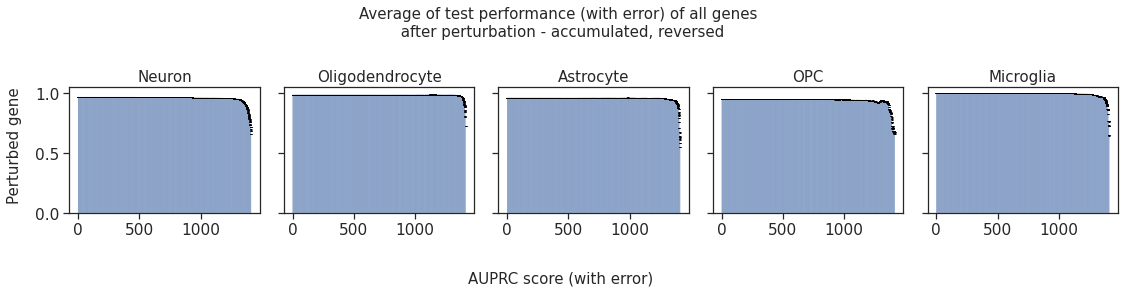

In [193]:
fig, axs  = plt.subplots(1,5, figsize=(16, 4), sharex=True, sharey=True)
sns.set(font_scale=1.4, style='ticks')
for i in cell_types:
    number = cell_types.index(i)
    scores = score_list[number]
    scores_df = pd.DataFrame(scores)
    scores_df['mean'] = scores_df.mean(axis=1)
    scores_df['std'] = scores_df.std(axis=1)
    
    axs[number].bar(np.arange(1413), scores_df['mean'] , yerr=scores_df['std'], snap=False, capsize=1,
                    color=sns.color_palette()[0], 
                    edgecolor=sns.color_palette()[0],
                    linewidth=0.005,ecolor='black')
#     axs[number].set_yticks(np.arange(nr_coefs))
#     axs[number].set_yticklabels(top_features, style='italic', fontsize=12)
    
#     axs[number].set_xticks((round(min(top_coefs), 1), 0, round(max(top_coefs), 1)))

    axs[number].set_title(f'{i}', fontsize=15)

fig.supxlabel('AUPRC score (with error)', fontsize=15)
fig.supylabel( 'Perturbed gene', fontsize=15)
fig.suptitle('Average of test performance (with error) of all genes \n after perturbation - accumulated, reversed', fontsize=15)
plt.tight_layout()
plt.savefig('../figures/4f_celltype_perturbation.pdf')

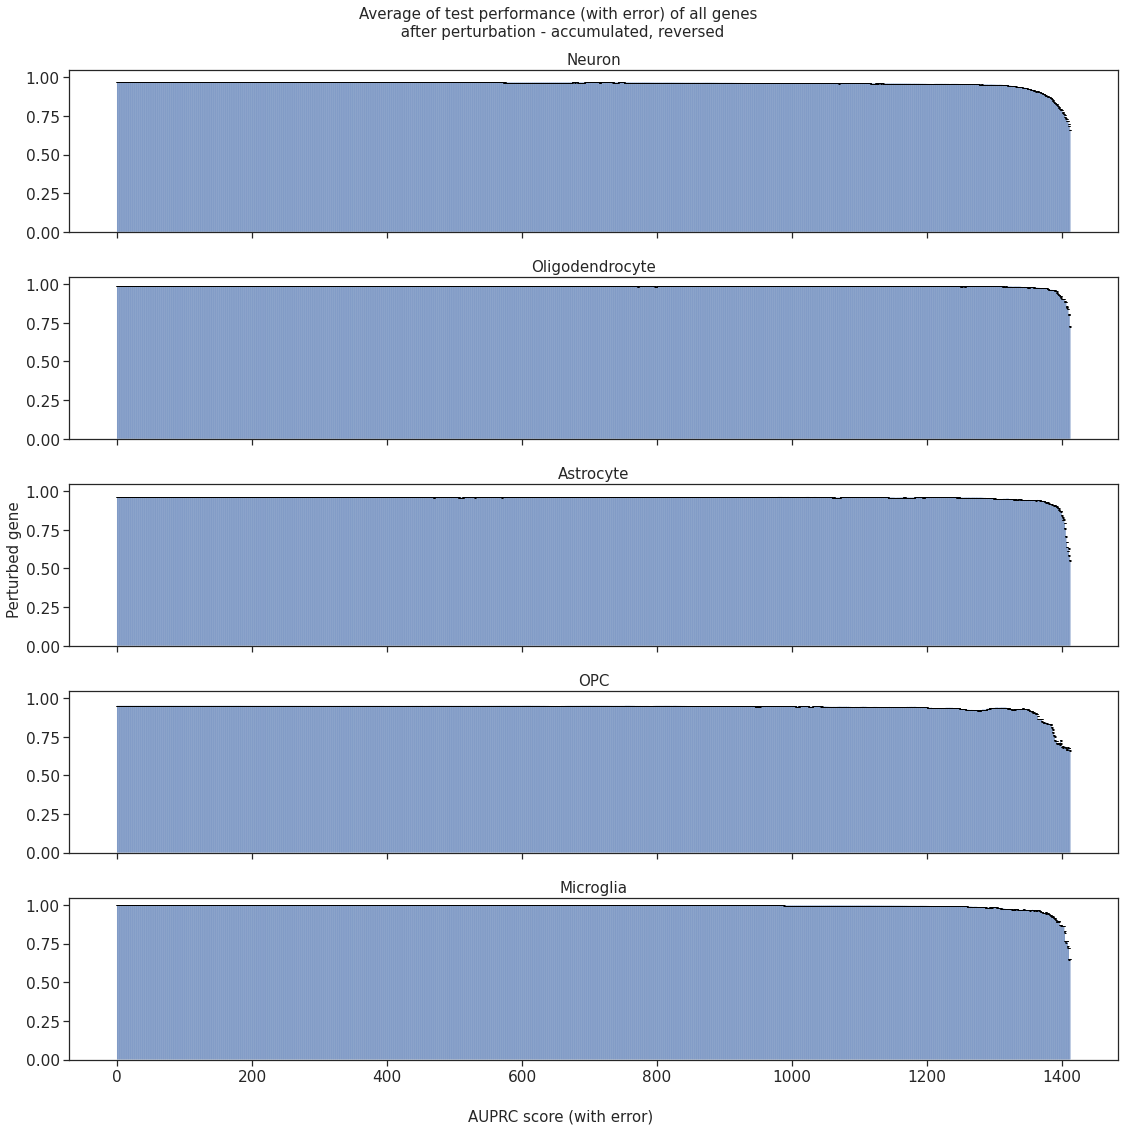

In [194]:
fig, axs  = plt.subplots(5,1, figsize=(16, 16), sharex=True, sharey=True)
sns.set(font_scale=1.4, style='ticks')
for i in cell_types:
    number = cell_types.index(i)
    scores = score_list[number]
    scores_df = pd.DataFrame(scores)
    scores_df['mean'] = scores_df.mean(axis=1)
    scores_df['std'] = scores_df.std(axis=1)
    
    axs[number].bar(np.arange(1413), scores_df['mean'] , yerr=scores_df['std'], snap=False, capsize=1,
                    color=sns.color_palette()[0], 
                    edgecolor=sns.color_palette()[0],
                    linewidth=0.005,ecolor='black')
#     axs[number].set_yticks(np.arange(nr_coefs))
#     axs[number].set_yticklabels(top_features, style='italic', fontsize=12)
    
#     axs[number].set_xticks((round(min(top_coefs), 1), 0, round(max(top_coefs), 1)))

    axs[number].set_title(f'{i}', fontsize=15)

fig.supxlabel('AUPRC score (with error)', fontsize=15)
fig.supylabel( 'Perturbed gene', fontsize=15)
fig.suptitle('Average of test performance (with error) of all genes \n after perturbation - accumulated, reversed', fontsize=15)
plt.tight_layout()
# plt.savefig('../figures/4f_celltype_perturbation.pdf')

In [199]:
top_200 = []
for i in range(5):
    features = ftr_names_list[i]
    features = features[-200:]
    features.reverse()
    top_200.append(features)

In [207]:
set(top_200[0]).intersection(top_200[1], top_200[2], top_200[3], top_200[4])

{'B230312C02Rik', 'Ly6a', 'Nes', 'Slc5a4b'}

In [210]:
cell_types

['Neuron', 'Oligodendrocyte', 'Astrocyte', 'OPC', 'Microglia']

In [215]:
top_400 = []
for i in range(5):
    features = ftr_names_list[i]
    features = features[-400:]
    features.reverse()
    top_400.append(features)

In [220]:
top_400[4]

['Efcab11',
 'Gm4951',
 'Col4a4',
 'Sp100',
 'Piezo2',
 'Col4a3',
 'Kntc1',
 'AW112010',
 'Ifitm3',
 'Ptger3',
 'Ccdc3',
 'Grpr',
 'Hormad1',
 'Fam129a',
 'Fndc3c1',
 'Epsti1',
 'Pla2g6',
 'Pdyn',
 'Mrc1',
 'Calcrl',
 'Cdkn3',
 'Dnaaf3',
 'Slc39a12',
 'Casp8',
 'Arhgap15',
 'Srgn',
 'Crh',
 'Rbpms',
 'Slc16a10',
 'Pthlh',
 '4930445E18Rik',
 'Kitl',
 'Knl1',
 'Cdh5',
 'Adam2',
 'Rad51b',
 'Dnah6',
 'Ly6a',
 'Ggta1',
 'A530053G22Rik',
 'AU020206',
 'Cdk6',
 'Eng',
 'Prkcd',
 'Tns1',
 'Ebf3',
 'Gm867',
 'Aqp4',
 'Frmpd2',
 'Aldh1a1',
 'Gcnt2',
 'Col27a1',
 'Tll2',
 'Slc5a4b',
 'A830008E24Rik',
 'Ets1',
 'Unc5cl',
 'Col12a1',
 'B230312C02Rik',
 'Abcc4',
 'Slc25a13',
 'Zfp13',
 'Ly6e',
 'Gm11290',
 'Agmo',
 'Mitf',
 'Slco1a4',
 'Igf2',
 'Meis1',
 'Cdc14a',
 'Nek5',
 'Slc22a8',
 'Hs3st3a1',
 'Dhdh',
 'Lpar1',
 'Pamr1',
 'Arhgap29',
 'Cavin1',
 'Cd34',
 'Gabrd',
 'Id1',
 'Tbx19',
 '4930500H12Rik',
 'Nes',
 'Wls',
 'Myo1e',
 'Klf2',
 'Acss1',
 'Itih5',
 'Npl',
 'Cartpt',
 'Itm2a',
 'Cnksr3',
 

### neuron: 64 zero-coefficient
174, 84, 202, 

from sklearn.inspection import permutation_importance
# acuumulated perturbation
np.random.seed(42)

ftr_names = ranked_list
nr_runs = 10

scores = np.zeros([len(ftr_names), nr_runs])

X_test, y_test = final_data[0]
grid = final_models[0]

# loop through the features
X_test_shuffled = X_test.copy()

for i in range(len(ftr_names)):
    print('shuffling '+ str(ftr_names[i]))
    
    auprc_scores = []
    for j in range(nr_runs):
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_shuffled[ftr_names[i]].values)
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
    print('shuffled test score:', np.around(np.mean(auprc_scores),4),'+/-', np.around(np.std(auprc_scores),4))
    scores[i] = auprc_scores

file = open('../results/cell_type_best/Microglia_scores_accumulated.save', 'wb')
pickle.dump(scores, file)
file.close()

In [17]:
file = open('../results/cell_type_best/Microglia_scores_accumulated.save', 'rb')
scores = pickle.load(file)
file.close()

FileNotFoundError: [Errno 2] No such file or directory: '../results/cell_type_best/Microglia_scores_accumulated.save'

In [19]:
scores_df = pd.DataFrame(scores)
scores_df['mean'] = scores_df.mean(axis=1)
scores_df['std'] = scores_df.std(axis=1)
scores_df['gene'] = ranked_list

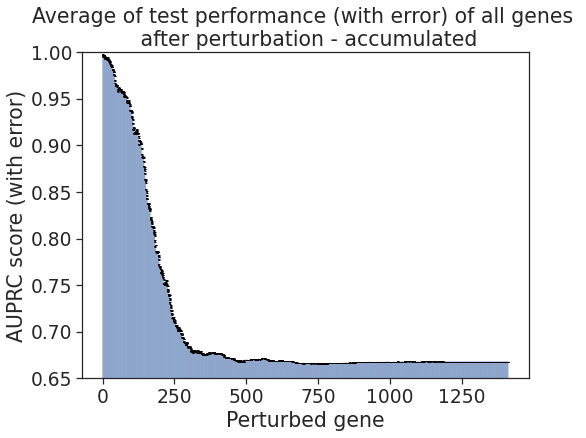

In [21]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.7, style='ticks')

plt.bar(np.arange(1413), scores_df['mean'] , yerr=scores_df['std'], snap=False, capsize=1,
        color=sns.color_palette()[0], 
        edgecolor=sns.color_palette()[0],
        linewidth=0.005,
        ecolor='black')

# plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel("AUPRC score (with error)")
plt.ylim(0.65, 1)
plt.xlabel('Perturbed gene')
plt.title("Average of test performance (with error) of all genes \n after perturbation - accumulated")
# plt.savefig('../figures/3c_accumulated_perturbation_coef_ranked.PDF', bbox_inches='tight')
# plt.grid(axis='y')
plt.show()

sns.lineplot(data=scores_df, x="gene", y="mean")

In [22]:
import scipy
import pylab
from scipy.misc import derivative

In [23]:
ftr_names = ranked_list

In [24]:
range(len(ranked_list))

range(0, 1413)

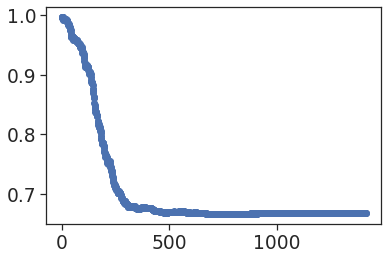

In [25]:
y0 = scipy.interpolate.interp1d(range(len(ftr_names)), scores_df['mean'], kind='nearest')
continuous_x = np.linspace(1, len(ftr_names)-2, len(ftr_names)-2)
plt.scatter(range(len(ftr_names)), scores_df['mean'])

<Figure size 576x432 with 0 Axes>

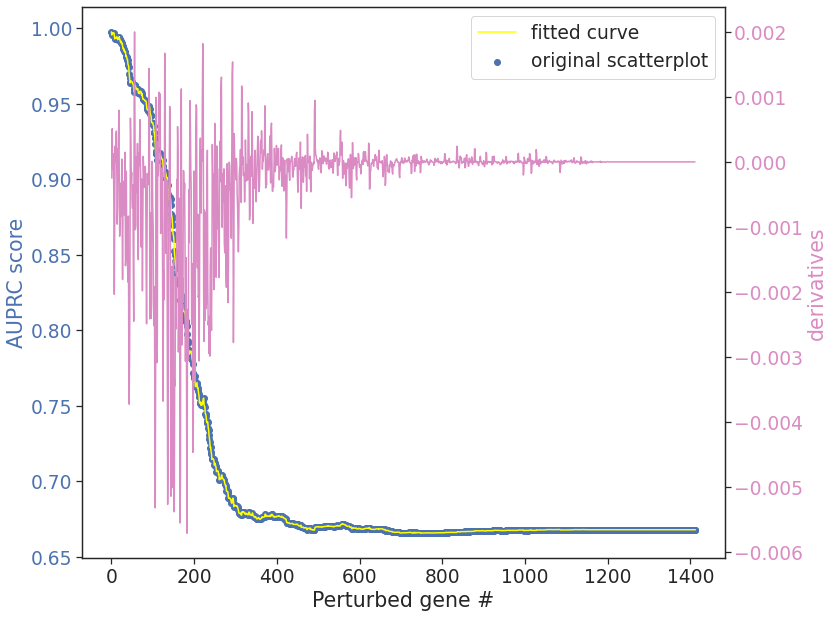

In [26]:
plt.figure(figsize=(8,6))

sns.set(font_scale=1.7, style='ticks')
fig, ax1 = plt.subplots(figsize=(12, 9))

color = sns.color_palette()[0]
ax1.set_xlabel('Perturbed gene #')
ax1.set_ylabel('AUPRC score', color=color)
ax1.scatter(range(len(ftr_names)), scores_df['mean'], label='data point', color=color)
ax1.plot(range(len(ftr_names)), y0(range(len(ftr_names))), label='nearest', color='yellow')
ax1.legend(['fitted curve', 'original scatterplot'])
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = sns.color_palette()[6]
ax2.set_ylabel('derivatives', color=color)  # we already handled the x-label with ax1
ax2.plot(continuous_x, derivative(y0, continuous_x), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('../figures/3d_accumulated_perturbation_derivatives.PDF', bbox_inches='tight')
plt.show()

In [28]:
from sklearn.inspection import permutation_importance
# acuumulated perturbation
np.random.seed(42)
nr_runs = 10

ftr_names.reverse()
scores = np.zeros([len(ftr_names), nr_runs])

X_test, y_test = final_data[0]
grid = final_models[0]

# loop through the features
X_test_shuffled = X_test.copy()

for i in range(len(ftr_names)):
    print('shuffling '+ str(ftr_names[i]))
    
    auprc_scores = []
    for j in range(nr_runs):
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_shuffled[ftr_names[i]].values)
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
    print('shuffled test score:', np.around(np.mean(auprc_scores),4),'+/-', np.around(np.std(auprc_scores),4))
    scores[i] = auprc_scores

shuffling Gm7967
shuffled test score: 0.9969 +/- 0.0
shuffling Lhx1os
shuffled test score: 0.9969 +/- 0.0
shuffling Gm16499
shuffled test score: 0.9969 +/- 0.0
shuffling Gm40437
shuffled test score: 0.9969 +/- 0.0
shuffling Arhgap28
shuffled test score: 0.9969 +/- 0.0
shuffling Lama3
shuffled test score: 0.9969 +/- 0.0
shuffling Scn5a
shuffled test score: 0.9969 +/- 0.0
shuffling Gm29865
shuffled test score: 0.9969 +/- 0.0
shuffling Scube2
shuffled test score: 0.9969 +/- 0.0
shuffling Gm2164
shuffled test score: 0.9969 +/- 0.0
shuffling Car8
shuffled test score: 0.9969 +/- 0.0
shuffling Vit
shuffled test score: 0.9969 +/- 0.0
shuffling Lancl3
shuffled test score: 0.9969 +/- 0.0
shuffling Agtr1a
shuffled test score: 0.9969 +/- 0.0
shuffling Cldn14
shuffled test score: 0.9969 +/- 0.0
shuffling Vwa5b1
shuffled test score: 0.9969 +/- 0.0
shuffling Gm816
shuffled test score: 0.9969 +/- 0.0
shuffling Pgm5
shuffled test score: 0.9969 +/- 0.0
shuffling Sox1ot
shuffled test score: 0.9969 +/- 0.

shuffled test score: 0.9969 +/- 0.0
shuffling Etnppl
shuffled test score: 0.9969 +/- 0.0
shuffling Pde11a
shuffled test score: 0.9969 +/- 0.0
shuffling Syne3
shuffled test score: 0.9969 +/- 0.0
shuffling 4930555F03Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Abcc9
shuffled test score: 0.9969 +/- 0.0
shuffling Gm2516
shuffled test score: 0.9969 +/- 0.0
shuffling Slc6a13
shuffled test score: 0.9969 +/- 0.0
shuffling Gm36431
shuffled test score: 0.9969 +/- 0.0
shuffling Rtp3
shuffled test score: 0.9969 +/- 0.0
shuffling Col19a1
shuffled test score: 0.9969 +/- 0.0
shuffling 2010001K21Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Car4
shuffled test score: 0.9969 +/- 0.0
shuffling Zfp366
shuffled test score: 0.9969 +/- 0.0
shuffling Gm26737
shuffled test score: 0.9969 +/- 0.0
shuffling B230216N24Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Slc13a4
shuffled test score: 0.9969 +/- 0.0
shuffling Gm31045
shuffled test score: 0.9969 +/- 0.0
shuffling Nox4
shuffled test score: 0.9969

shuffled test score: 0.9969 +/- 0.0
shuffling Prkg2
shuffled test score: 0.9969 +/- 0.0
shuffling Gpr176
shuffled test score: 0.9969 +/- 0.0
shuffling Nfia
shuffled test score: 0.9969 +/- 0.0
shuffling Mei4
shuffled test score: 0.9969 +/- 0.0
shuffling Gpr83
shuffled test score: 0.9969 +/- 0.0
shuffling Edaradd
shuffled test score: 0.9969 +/- 0.0
shuffling Mettl18
shuffled test score: 0.9969 +/- 0.0
shuffling Chrm3
shuffled test score: 0.9969 +/- 0.0
shuffling Trpc7
shuffled test score: 0.9969 +/- 0.0
shuffling Plch1
shuffled test score: 0.9969 +/- 0.0
shuffling Ptprj
shuffled test score: 0.9969 +/- 0.0
shuffling Sema3a
shuffled test score: 0.9969 +/- 0.0
shuffling Slc7a10
shuffled test score: 0.9969 +/- 0.0
shuffling Dnah9
shuffled test score: 0.9969 +/- 0.0
shuffling Gm29478
shuffled test score: 0.9969 +/- 0.0
shuffling Ipcef1
shuffled test score: 0.9969 +/- 0.0
shuffling Gfra1
shuffled test score: 0.9969 +/- 0.0
shuffling Rgs7
shuffled test score: 0.9969 +/- 0.0
shuffling Lix1
shuff

shuffled test score: 0.9969 +/- 0.0
shuffling Galnt18
shuffled test score: 0.9969 +/- 0.0
shuffling Gfap
shuffled test score: 0.9969 +/- 0.0
shuffling Tcf7l1
shuffled test score: 0.9969 +/- 0.0
shuffling Cdh4
shuffled test score: 0.9969 +/- 0.0
shuffling Lrrc36
shuffled test score: 0.9969 +/- 0.0
shuffling 6530403H02Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Kit
shuffled test score: 0.9969 +/- 0.0
shuffling Adamts20
shuffled test score: 0.9969 +/- 0.0
shuffling Gm48727
shuffled test score: 0.9969 +/- 0.0
shuffling Skap1
shuffled test score: 0.9969 +/- 0.0
shuffling Nostrin
shuffled test score: 0.9969 +/- 0.0
shuffling Spag16
shuffled test score: 0.9969 +/- 0.0
shuffling Kirrel3
shuffled test score: 0.9969 +/- 0.0
shuffling Pifo
shuffled test score: 0.9969 +/- 0.0
shuffling 9130410C08Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Col5a2
shuffled test score: 0.9969 +/- 0.0
shuffling Epb41l4a
shuffled test score: 0.9969 +/- 0.0
shuffling Col4a5
shuffled test score: 0.9969 +/- 0.

shuffled test score: 0.9969 +/- 0.0
shuffling Dcc
shuffled test score: 0.9969 +/- 0.0
shuffling Luzp2
shuffled test score: 0.9969 +/- 0.0
shuffling Sim1
shuffled test score: 0.997 +/- 0.0
shuffling Nek10
shuffled test score: 0.997 +/- 0.0
shuffling Gm16168
shuffled test score: 0.997 +/- 0.0
shuffling Dscaml1
shuffled test score: 0.997 +/- 0.0
shuffling Zfp804b
shuffled test score: 0.997 +/- 0.0
shuffling Dlk1
shuffled test score: 0.997 +/- 0.0
shuffling Socs2
shuffled test score: 0.997 +/- 0.0
shuffling Crtac1
shuffled test score: 0.997 +/- 0.0
shuffling Trpc6
shuffled test score: 0.997 +/- 0.0
shuffling Dach1
shuffled test score: 0.997 +/- 0.0
shuffling Pdgfd
shuffled test score: 0.997 +/- 0.0
shuffling Gm42722
shuffled test score: 0.997 +/- 0.0
shuffling Gm2824
shuffled test score: 0.997 +/- 0.0
shuffling Egfem1
shuffled test score: 0.997 +/- 0.0
shuffling A2m
shuffled test score: 0.997 +/- 0.0
shuffling Ccdc141
shuffled test score: 0.997 +/- 0.0
shuffling Ghr
shuffled test score: 0.

shuffled test score: 0.9969 +/- 0.0
shuffling Calcr
shuffled test score: 0.9969 +/- 0.0
shuffling Kank1
shuffled test score: 0.9969 +/- 0.0
shuffling Mgat5b
shuffled test score: 0.9969 +/- 0.0
shuffling Heatr5a
shuffled test score: 0.9969 +/- 0.0
shuffling Dach2
shuffled test score: 0.9969 +/- 0.0
shuffling Tmem132c
shuffled test score: 0.9969 +/- 0.0
shuffling Sel1l3
shuffled test score: 0.9969 +/- 0.0
shuffling Bcan
shuffled test score: 0.9969 +/- 0.0
shuffling 4930447C04Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Isl1
shuffled test score: 0.9969 +/- 0.0
shuffling Ccnd3
shuffled test score: 0.997 +/- 0.0
shuffling Plekhh1
shuffled test score: 0.9969 +/- 0.0
shuffling Sfta3-ps
shuffled test score: 0.9969 +/- 0.0
shuffling Rarb
shuffled test score: 0.9969 +/- 0.0
shuffling Trpm3
shuffled test score: 0.9969 +/- 0.0
shuffling Ptprt
shuffled test score: 0.9969 +/- 0.0
shuffling Maml3
shuffled test score: 0.9969 +/- 0.0
shuffling Chrm2
shuffled test score: 0.9969 +/- 0.0
shuffling Il

shuffled test score: 0.9968 +/- 0.0
shuffling Gm15155
shuffled test score: 0.9968 +/- 0.0
shuffling C030005K06Rik
shuffled test score: 0.9968 +/- 0.0
shuffling Lrmda
shuffled test score: 0.9968 +/- 0.0
shuffling Epha6
shuffled test score: 0.9968 +/- 0.0
shuffling Gabrg1
shuffled test score: 0.9968 +/- 0.0
shuffling Elmo1
shuffled test score: 0.9968 +/- 0.0
shuffling Grin2a
shuffled test score: 0.9968 +/- 0.0
shuffling Prr16
shuffled test score: 0.9968 +/- 0.0
shuffling Blnk
shuffled test score: 0.9968 +/- 0.0
shuffling Fat1
shuffled test score: 0.9968 +/- 0.0
shuffling Cntn4
shuffled test score: 0.9968 +/- 0.0
shuffling Vat1l
shuffled test score: 0.9968 +/- 0.0
shuffling Trpc5
shuffled test score: 0.9968 +/- 0.0
shuffling Dab1
shuffled test score: 0.9968 +/- 0.0
shuffling Myo1f
shuffled test score: 0.9968 +/- 0.0
shuffling Ube2cbp
shuffled test score: 0.9968 +/- 0.0
shuffling Man2a1
shuffled test score: 0.9968 +/- 0.0
shuffling Slc1a2
shuffled test score: 0.9968 +/- 0.0
shuffling Ripor

shuffled test score: 0.9963 +/- 0.0
shuffling Gm26871
shuffled test score: 0.9963 +/- 0.0
shuffling Slc7a8
shuffled test score: 0.9964 +/- 0.0
shuffling Crim1
shuffled test score: 0.9964 +/- 0.0
shuffling Rgs22
shuffled test score: 0.9964 +/- 0.0
shuffling Mt2
shuffled test score: 0.9964 +/- 0.0
shuffling Adcy8
shuffled test score: 0.9964 +/- 0.0
shuffling Thrb
shuffled test score: 0.9964 +/- 0.0
shuffling Satb1
shuffled test score: 0.9964 +/- 0.0
shuffling Il33
shuffled test score: 0.9964 +/- 0.0
shuffling Slc24a3
shuffled test score: 0.9964 +/- 0.0
shuffling Mctp1
shuffled test score: 0.9963 +/- 0.0
shuffling Pmch
shuffled test score: 0.9963 +/- 0.0
shuffling Unc5d
shuffled test score: 0.9963 +/- 0.0
shuffling St6galnac5
shuffled test score: 0.9963 +/- 0.0
shuffling Bank1
shuffled test score: 0.9963 +/- 0.0
shuffling Hlf
shuffled test score: 0.9963 +/- 0.0
shuffling Tcf7l2
shuffled test score: 0.9964 +/- 0.0
shuffling Inpp5k
shuffled test score: 0.9964 +/- 0.0
shuffling Vgf
shuffled 

shuffled test score: 0.9928 +/- 0.0001
shuffling Ccdc162
shuffled test score: 0.9929 +/- 0.0
shuffling Apoe
shuffled test score: 0.9924 +/- 0.0002
shuffling Sst
shuffled test score: 0.9926 +/- 0.0001
shuffling Mal
shuffled test score: 0.9928 +/- 0.0
shuffling Lhfpl2
shuffled test score: 0.9928 +/- 0.0002
shuffling Jcad
shuffled test score: 0.9928 +/- 0.0
shuffling Gab1
shuffled test score: 0.9926 +/- 0.0001
shuffling Nfe2l2
shuffled test score: 0.9925 +/- 0.0001
shuffling Spag17
shuffled test score: 0.9922 +/- 0.0001
shuffling Pla2g4a
shuffled test score: 0.9913 +/- 0.0001
shuffling Pik3ap1
shuffled test score: 0.9913 +/- 0.0001
shuffling Trh
shuffled test score: 0.9909 +/- 0.0001
shuffling 2810403D21Rik
shuffled test score: 0.9903 +/- 0.0001
shuffling C730034F03Rik
shuffled test score: 0.9898 +/- 0.0001
shuffling Man1a
shuffled test score: 0.99 +/- 0.0002
shuffling Pvt1
shuffled test score: 0.99 +/- 0.0001
shuffling Ranbp3l
shuffled test score: 0.9891 +/- 0.0001
shuffling Bnc2
shuffle

shuffled test score: 0.8512 +/- 0.0028
shuffling Grpr
shuffled test score: 0.849 +/- 0.0
shuffling Ccdc3
shuffled test score: 0.849 +/- 0.0
shuffling Ptger3
shuffled test score: 0.8487 +/- 0.0003
shuffling Ifitm3
shuffled test score: 0.8147 +/- 0.0036
shuffling AW112010
shuffled test score: 0.7667 +/- 0.005
shuffling Kntc1
shuffled test score: 0.7554 +/- 0.0037
shuffling Col4a3
shuffled test score: 0.7565 +/- 0.0
shuffling Piezo2
shuffled test score: 0.7565 +/- 0.0
shuffling Sp100
shuffled test score: 0.7107 +/- 0.0048
shuffling Col4a4
shuffled test score: 0.7133 +/- 0.0024
shuffling Gm4951
shuffled test score: 0.6369 +/- 0.0029
shuffling Efcab11
shuffled test score: 0.6498 +/- 0.0029


In [31]:
X_test_shuffle_original = X_test_shuffled.copy()

In [38]:
X_test_shuffled[ftr_names[1000:]] = X_test.iloc[:, 1000:]

In [39]:
y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
auc(recall, precision)

0.9221143699125094

In [40]:
X_test_shuffled = X_test_shuffle_original.copy()

In [41]:
X_test_shuffled[ftr_names[1318:]] = X_test.iloc[:, 1318:]
y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
auc(recall, precision)

0.8778452202210381

In [42]:
file = open('../results/cell_type_best/Microglia_scores_accumulated_reversed.save', 'wb')
pickle.dump(scores, file)
file.close()

scores_df = pd.DataFrame(scores)
scores_df['mean'] = scores_df.mean(axis=1)
scores_df['std'] = scores_df.std(axis=1)
scores_df['gene'] = ftr_names

In [166]:
scores_df = pd.DataFrame(scores)
scores_df

,0,1,2,3,4,5,6,7,8,9,...,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412
0,-0.032812,-0.300880,0.226245,0.006428,-0.183085,-0.412043,0.059882,0.231874,-0.284169,-0.347428,...,-0.243119,-0.075075,-0.415309,0.065318,2.416318e-08,0.124036,-0.013809,0.219304,-0.179463,0.037724
1,0.000103,0.000099,0.000092,0.000087,0.000097,0.000088,0.000094,0.000082,0.000146,0.000084,...,0.000063,0.000047,0.000005,0.000018,4.797663e-08,0.000044,0.000046,0.000020,0.000081,0.000009


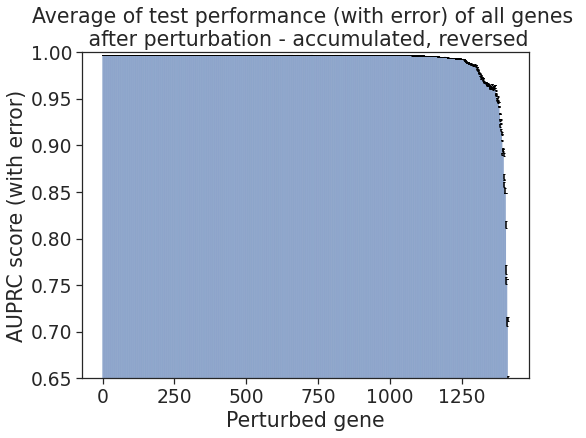

In [44]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.7, style='ticks')

plt.bar(np.arange(1413), scores_df['mean'] , yerr=scores_df['std'], snap=False, capsize=1,
        color=sns.color_palette()[0], 
        edgecolor=sns.color_palette()[0],
        linewidth=0.005,
        ecolor='black')

# plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel("AUPRC score (with error)")
plt.ylim(0.65, 1)
plt.xlabel('Perturbed gene')
plt.title("Average of test performance (with error) of all genes \n after perturbation - accumulated, reversed")
#plt.savefig('../figures/3c_accumulated_perturbation_coef_ranked_reversed.PDF', bbox_inches='tight')
# plt.grid(axis='y')
plt.show()

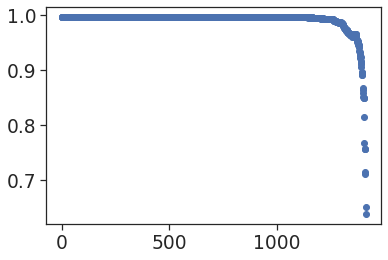

In [45]:
y0 = scipy.interpolate.interp1d(range(len(ftr_names)), scores_df['mean'], kind='nearest')
continuous_x = np.linspace(1, len(ftr_names)-2, len(ftr_names)-2)
plt.scatter(range(len(ftr_names)), scores_df['mean'])

In [46]:
scores_df

,0,1,2,3,4,5,6,7,8,9,mean,std,gene
0,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,1.164412e-16,Gm7967
1,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,1.164412e-16,Lhx1os
2,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,1.164412e-16,Gm16499
3,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,1.164412e-16,Gm40437
4,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,0.996890,1.164412e-16,Arhgap28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,0.756477,0.756477,0.756477,0.756477,0.756477,0.756477,0.756477,0.756477,0.756477,0.756477,0.756477,0.000000e+00,Piezo2
1409,0.706617,0.711864,0.711271,0.719286,0.713482,0.713575,0.701323,0.711933,0.705487,0.712368,0.710721,4.769413e-03,Sp100
1410,0.715729,0.710256,0.714135,0.715169,0.710497,0.709211,0.715714,0.713295,0.713434,0.715750,0.713319,2.361764e-03,Col4a4
1411,0.637297,0.636268,0.632683,0.634600,0.635097,0.640554,0.638344,0.637597,0.633693,0.642596,0.636873,2.924602e-03,Gm4951


<Figure size 576x432 with 0 Axes>

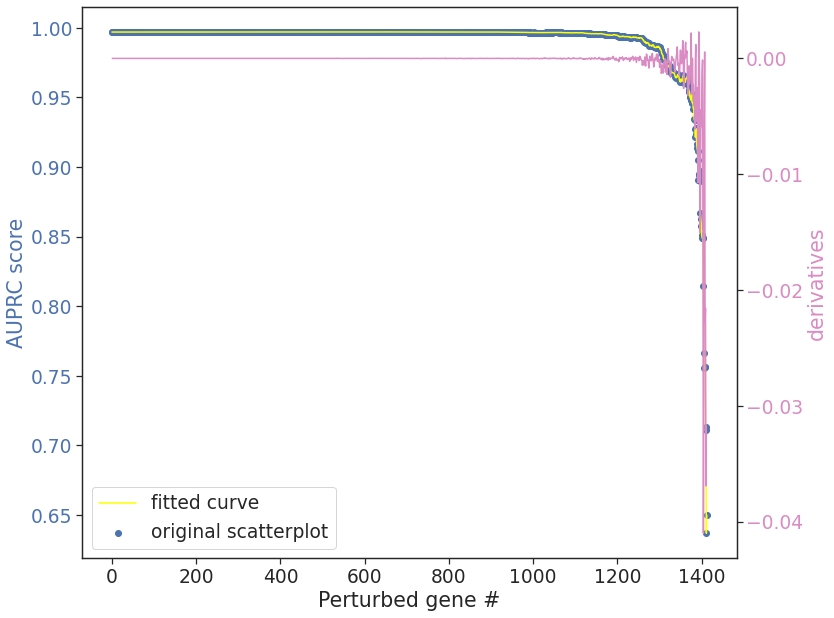

In [47]:
plt.figure(figsize=(8,6))

sns.set(font_scale=1.7, style='ticks')
fig, ax1 = plt.subplots(figsize=(12, 9))

color = sns.color_palette()[0]
ax1.set_xlabel('Perturbed gene #')
ax1.set_ylabel('AUPRC score', color=color)
ax1.scatter(range(len(ftr_names)), scores_df['mean'], label='data point', color=color)
ax1.plot(range(len(ftr_names)), y0(range(len(ftr_names))), label='nearest', color='yellow')
ax1.legend(['fitted curve', 'original scatterplot'])
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = sns.color_palette()[6]
ax2.set_ylabel('derivatives', color=color)  # we already handled the x-label with ax1
ax2.plot(continuous_x, derivative(y0, continuous_x), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('../figures/3d_accumulated_perturbation_derivatives_reversed.PDF', bbox_inches='tight')
plt.show()

In [48]:
X_test_shuffled = X_test_shuffle_original.copy()

In [49]:
ranked_list.reverse()

In [50]:
from sklearn.inspection import permutation_importance
# acuumulated perturbation
np.random.seed(42)

ftr_names = ranked_list
nr_runs = 10

scores = np.zeros([len(ftr_names), nr_runs])

X_test, y_test = final_data[0]
grid = final_models[0]

# loop through the features
X_test_shuffled = X_test_shuffle_original.copy()

for i in range(len(ftr_names)):
    print('shuffling '+ str(ftr_names[i]))
    
    auprc_scores = []
    for j in range(nr_runs):
        X_test_shuffled[ftr_names[i]] = X_test[ftr_names[i]]
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
    print('shuffled test score:', np.around(np.mean(auprc_scores),4),'+/-', np.around(np.std(auprc_scores),4))
    scores[i] = auprc_scores

shuffling Efcab11
shuffled test score: 0.6426 +/- 0.0
shuffling Gm4951
shuffled test score: 0.7158 +/- 0.0
shuffling Col4a4
shuffled test score: 0.7124 +/- 0.0
shuffling Sp100
shuffled test score: 0.7565 +/- 0.0
shuffling Piezo2
shuffled test score: 0.7565 +/- 0.0
shuffling Col4a3
shuffled test score: 0.7565 +/- 0.0
shuffling Kntc1
shuffled test score: 0.7677 +/- 0.0
shuffling AW112010
shuffled test score: 0.8172 +/- 0.0
shuffling Ifitm3
shuffled test score: 0.8489 +/- 0.0
shuffling Ptger3
shuffled test score: 0.849 +/- 0.0
shuffling Ccdc3
shuffled test score: 0.849 +/- 0.0
shuffling Grpr
shuffled test score: 0.849 +/- 0.0
shuffling Hormad1
shuffled test score: 0.8567 +/- 0.0
shuffling Fam129a
shuffled test score: 0.8629 +/- 0.0
shuffling Fndc3c1
shuffled test score: 0.8629 +/- 0.0
shuffling Epsti1
shuffled test score: 0.89 +/- 0.0
shuffling Pla2g6
shuffled test score: 0.8959 +/- 0.0
shuffling Pdyn
shuffled test score: 0.8949 +/- 0.0
shuffling Mrc1
shuffled test score: 0.8963 +/- 0.0
s

shuffled test score: 0.9928 +/- 0.0
shuffling Sst
shuffled test score: 0.9926 +/- 0.0
shuffling Apoe
shuffled test score: 0.9929 +/- 0.0
shuffling Ccdc162
shuffled test score: 0.9929 +/- 0.0
shuffling Fgd2
shuffled test score: 0.9928 +/- 0.0
shuffling Anxa3
shuffled test score: 0.9928 +/- 0.0
shuffling Lin9
shuffled test score: 0.9927 +/- 0.0
shuffling Pdgfra
shuffled test score: 0.9927 +/- 0.0
shuffling Armc3
shuffled test score: 0.9929 +/- 0.0
shuffling Rec114
shuffled test score: 0.9933 +/- 0.0
shuffling Pde8a
shuffled test score: 0.9932 +/- 0.0
shuffling Cenpf
shuffled test score: 0.9931 +/- 0.0
shuffling Lypd6
shuffled test score: 0.9931 +/- 0.0
shuffling Svil
shuffled test score: 0.9929 +/- 0.0
shuffling Kcnk13
shuffled test score: 0.993 +/- 0.0
shuffling Ildr2
shuffled test score: 0.9934 +/- 0.0
shuffling Slc6a20a
shuffled test score: 0.9934 +/- 0.0
shuffling 1700034P13Rik
shuffled test score: 0.9931 +/- 0.0
shuffling Cd247
shuffled test score: 0.9931 +/- 0.0
shuffling Zfp808
sh

shuffled test score: 0.9963 +/- 0.0
shuffling Tnr
shuffled test score: 0.9963 +/- 0.0
shuffling Avp
shuffled test score: 0.9963 +/- 0.0
shuffling Hk2
shuffled test score: 0.9964 +/- 0.0
shuffling Nnat
shuffled test score: 0.9963 +/- 0.0
shuffling Arhgap6
shuffled test score: 0.9963 +/- 0.0
shuffling Ly6c1
shuffled test score: 0.9964 +/- 0.0
shuffling Tafa1
shuffled test score: 0.9964 +/- 0.0
shuffling Creb5
shuffled test score: 0.9964 +/- 0.0
shuffling Serpine2
shuffled test score: 0.9965 +/- 0.0
shuffling Myo1b
shuffled test score: 0.9964 +/- 0.0
shuffling Hdc
shuffled test score: 0.9964 +/- 0.0
shuffling Dgkb
shuffled test score: 0.9964 +/- 0.0
shuffling Oxt
shuffled test score: 0.9963 +/- 0.0
shuffling Cd38
shuffled test score: 0.9964 +/- 0.0
shuffling Rbfox1
shuffled test score: 0.9964 +/- 0.0
shuffling Epha5
shuffled test score: 0.9964 +/- 0.0
shuffling Armc4
shuffled test score: 0.9964 +/- 0.0
shuffling F730043M19Rik
shuffled test score: 0.9965 +/- 0.0
shuffling Pla2g7
shuffled t

shuffled test score: 0.9969 +/- 0.0
shuffling Adap2
shuffled test score: 0.9968 +/- 0.0
shuffling C130073E24Rik
shuffled test score: 0.9968 +/- 0.0
shuffling Nrn1
shuffled test score: 0.9968 +/- 0.0
shuffling Ebf1
shuffled test score: 0.9968 +/- 0.0
shuffling Nell2
shuffled test score: 0.9968 +/- 0.0
shuffling Tmtc2
shuffled test score: 0.9968 +/- 0.0
shuffling Zeb2
shuffled test score: 0.9969 +/- 0.0
shuffling C77080
shuffled test score: 0.9968 +/- 0.0
shuffling Ptch1
shuffled test score: 0.9969 +/- 0.0
shuffling Oprm1
shuffled test score: 0.9969 +/- 0.0
shuffling Kcnq5
shuffled test score: 0.9969 +/- 0.0
shuffling Fbxl7
shuffled test score: 0.9969 +/- 0.0
shuffling Armc2
shuffled test score: 0.9969 +/- 0.0
shuffling Sox10
shuffled test score: 0.9969 +/- 0.0
shuffling Cpne4
shuffled test score: 0.9969 +/- 0.0
shuffling Car10
shuffled test score: 0.9969 +/- 0.0
shuffling Gm16083
shuffled test score: 0.9969 +/- 0.0
shuffling Phactr1
shuffled test score: 0.9969 +/- 0.0
shuffling Aebp1
sh

shuffled test score: 0.9969 +/- 0.0
shuffling Fstl4
shuffled test score: 0.9969 +/- 0.0
shuffling Rgs6
shuffled test score: 0.9969 +/- 0.0
shuffling Zfp423
shuffled test score: 0.9969 +/- 0.0
shuffling Pik3r3
shuffled test score: 0.9969 +/- 0.0
shuffling Ednrb
shuffled test score: 0.9969 +/- 0.0
shuffling Col8a1
shuffled test score: 0.9969 +/- 0.0
shuffling Mog
shuffled test score: 0.9969 +/- 0.0
shuffling Pdzd2
shuffled test score: 0.9969 +/- 0.0
shuffling Nts
shuffled test score: 0.9969 +/- 0.0
shuffling Mcc
shuffled test score: 0.9969 +/- 0.0
shuffling Grik1
shuffled test score: 0.9969 +/- 0.0
shuffling Btbd11
shuffled test score: 0.9969 +/- 0.0
shuffling Sema5a
shuffled test score: 0.9969 +/- 0.0
shuffling Erbb4
shuffled test score: 0.9969 +/- 0.0
shuffling Asb4
shuffled test score: 0.9969 +/- 0.0
shuffling Bcl11b
shuffled test score: 0.9969 +/- 0.0
shuffling Gfra2
shuffled test score: 0.9969 +/- 0.0
shuffling Satb2
shuffled test score: 0.9969 +/- 0.0
shuffling Plppr1
shuffled test

shuffled test score: 0.9969 +/- 0.0
shuffling Synpo2
shuffled test score: 0.9969 +/- 0.0
shuffling Epas1
shuffled test score: 0.9969 +/- 0.0
shuffling Gm30382
shuffled test score: 0.9969 +/- 0.0
shuffling Gad1
shuffled test score: 0.9969 +/- 0.0
shuffling Cobll1
shuffled test score: 0.9969 +/- 0.0
shuffling Gm45904
shuffled test score: 0.9969 +/- 0.0
shuffling Cdh7
shuffled test score: 0.9969 +/- 0.0
shuffling Grin3a
shuffled test score: 0.9969 +/- 0.0
shuffling Ak7
shuffled test score: 0.9969 +/- 0.0
shuffling Lemd1
shuffled test score: 0.9969 +/- 0.0
shuffling Ano5
shuffled test score: 0.9969 +/- 0.0
shuffling Grip1
shuffled test score: 0.9969 +/- 0.0
shuffling Lzts1
shuffled test score: 0.9969 +/- 0.0
shuffling Gm32442
shuffled test score: 0.9969 +/- 0.0
shuffling Bmp6
shuffled test score: 0.9969 +/- 0.0
shuffling Rab3b
shuffled test score: 0.9969 +/- 0.0
shuffling Gzmk
shuffled test score: 0.9969 +/- 0.0
shuffling Gm32828
shuffled test score: 0.9969 +/- 0.0
shuffling Drd2
shuffled 

shuffled test score: 0.9969 +/- 0.0
shuffling Lin7a
shuffled test score: 0.9969 +/- 0.0
shuffling Arpp21
shuffled test score: 0.9969 +/- 0.0
shuffling 9630013A20Rik
shuffled test score: 0.9969 +/- 0.0
shuffling Pde7b
shuffled test score: 0.9969 +/- 0.0
shuffling Ret
shuffled test score: 0.9969 +/- 0.0
shuffling Ndst4
shuffled test score: 0.9969 +/- 0.0
shuffling Mro
shuffled test score: 0.9969 +/- 0.0
shuffling Dlx6os1
shuffled test score: 0.9969 +/- 0.0
shuffling Ndst3
shuffled test score: 0.9969 +/- 0.0
shuffling Gm7854
shuffled test score: 0.9969 +/- 0.0
shuffling Ptchd1
shuffled test score: 0.9969 +/- 0.0
shuffling Nckap5
shuffled test score: 0.9969 +/- 0.0
shuffling Cacng3
shuffled test score: 0.9969 +/- 0.0
shuffling Gm5149
shuffled test score: 0.9969 +/- 0.0
shuffling Kcnh1
shuffled test score: 0.9969 +/- 0.0
shuffling En1
shuffled test score: 0.9969 +/- 0.0
shuffling Gm45680
shuffled test score: 0.9969 +/- 0.0
shuffling Gm44593
shuffled test score: 0.9969 +/- 0.0
shuffling Onec

shuffled test score: 0.9969 +/- 0.0
shuffling Fbn2
shuffled test score: 0.9969 +/- 0.0
shuffling Pde10a
shuffled test score: 0.9969 +/- 0.0
shuffling Hcrtr2
shuffled test score: 0.9969 +/- 0.0
shuffling Pou6f2
shuffled test score: 0.9969 +/- 0.0
shuffling Sh3rf3
shuffled test score: 0.9969 +/- 0.0
shuffling Slco1c1
shuffled test score: 0.9969 +/- 0.0
shuffling Cecr2
shuffled test score: 0.9969 +/- 0.0
shuffling Ano4
shuffled test score: 0.9969 +/- 0.0
shuffling Syt6
shuffled test score: 0.9969 +/- 0.0
shuffling Ptpn13
shuffled test score: 0.9969 +/- 0.0
shuffling C1ql1
shuffled test score: 0.9969 +/- 0.0
shuffling Cacna2d3
shuffled test score: 0.9969 +/- 0.0
shuffling Rbm20
shuffled test score: 0.9969 +/- 0.0
shuffling Syt17
shuffled test score: 0.9969 +/- 0.0
shuffling Rorb
shuffled test score: 0.9969 +/- 0.0
shuffling Htr7
shuffled test score: 0.9969 +/- 0.0
shuffling Plce1
shuffled test score: 0.9969 +/- 0.0
shuffling Syt10
shuffled test score: 0.9969 +/- 0.0
shuffling Ddx60
shuffle

shuffled test score: 0.9969 +/- 0.0
shuffling Esam
shuffled test score: 0.9969 +/- 0.0
shuffling Chrna6
shuffled test score: 0.9969 +/- 0.0
shuffling Slc26a7
shuffled test score: 0.9969 +/- 0.0
shuffling Bmpr1b
shuffled test score: 0.9969 +/- 0.0
shuffling Tmem45b
shuffled test score: 0.9969 +/- 0.0
shuffling Slc38a11
shuffled test score: 0.9969 +/- 0.0
shuffling Aspa
shuffled test score: 0.9969 +/- 0.0
shuffling Ror1
shuffled test score: 0.9969 +/- 0.0
shuffling Postn
shuffled test score: 0.9969 +/- 0.0
shuffling Foxq1
shuffled test score: 0.9969 +/- 0.0
shuffling Gm28376
shuffled test score: 0.9969 +/- 0.0
shuffling Pde3a
shuffled test score: 0.9969 +/- 0.0
shuffling Cngb3
shuffled test score: 0.9969 +/- 0.0
shuffling Gm30613
shuffled test score: 0.9969 +/- 0.0
shuffling Kif6
shuffled test score: 0.9969 +/- 0.0
shuffling Prom1
shuffled test score: 0.9969 +/- 0.0
shuffling Col24a1
shuffled test score: 0.9969 +/- 0.0
shuffling Sntb1
shuffled test score: 0.9969 +/- 0.0
shuffling Gm19303

shuffled test score: 0.9969 +/- 0.0


In [52]:
ftr_names.index('Dhdh')

73

In [53]:
ftr_names[0:80]

['Efcab11',
 'Gm4951',
 'Col4a4',
 'Sp100',
 'Piezo2',
 'Col4a3',
 'Kntc1',
 'AW112010',
 'Ifitm3',
 'Ptger3',
 'Ccdc3',
 'Grpr',
 'Hormad1',
 'Fam129a',
 'Fndc3c1',
 'Epsti1',
 'Pla2g6',
 'Pdyn',
 'Mrc1',
 'Calcrl',
 'Cdkn3',
 'Dnaaf3',
 'Slc39a12',
 'Casp8',
 'Arhgap15',
 'Srgn',
 'Crh',
 'Rbpms',
 'Slc16a10',
 'Pthlh',
 '4930445E18Rik',
 'Kitl',
 'Knl1',
 'Cdh5',
 'Adam2',
 'Rad51b',
 'Dnah6',
 'Ly6a',
 'Ggta1',
 'A530053G22Rik',
 'AU020206',
 'Cdk6',
 'Eng',
 'Prkcd',
 'Tns1',
 'Ebf3',
 'Gm867',
 'Aqp4',
 'Frmpd2',
 'Aldh1a1',
 'Gcnt2',
 'Col27a1',
 'Tll2',
 'Slc5a4b',
 'A830008E24Rik',
 'Ets1',
 'Unc5cl',
 'Col12a1',
 'B230312C02Rik',
 'Abcc4',
 'Slc25a13',
 'Zfp13',
 'Ly6e',
 'Gm11290',
 'Agmo',
 'Mitf',
 'Slco1a4',
 'Igf2',
 'Meis1',
 'Cdc14a',
 'Nek5',
 'Slc22a8',
 'Hs3st3a1',
 'Dhdh',
 'Lpar1',
 'Pamr1',
 'Arhgap29',
 'Cavin1',
 'Cd34',
 'Gabrd']

In [54]:
file = open('../results/cell_type_best/Microglia_scores_reconstituted.save', 'wb')
pickle.dump(scores, file)
file.close()

scores_df = pd.DataFrame(scores)
scores_df['mean'] = scores_df.mean(axis=1)
scores_df['std'] = scores_df.std(axis=1)
scores_df['gene'] = ftr_names

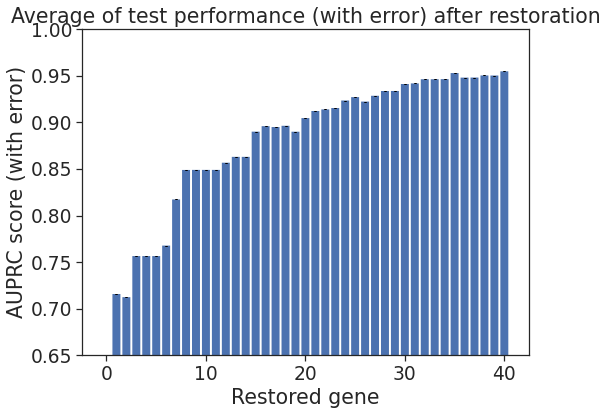

In [57]:
scores_df = pd.DataFrame(scores)
scores_df['mean'] = scores_df.mean(axis=1)
scores_df['std'] = scores_df.std(axis=1)
scores_df['gene'] = ftr_names

plt.figure(figsize=(8,6))
sns.set(font_scale=1.7, style='ticks')

plt.bar(np.arange(41), scores_df.loc[0:40,:]['mean'] , yerr=scores_df.loc[0:40,:]['std'], snap=False, capsize=1,
        color=sns.color_palette()[0], 
        edgecolor=sns.color_palette()[0],
        linewidth=0.005,
        ecolor='black')

# plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel("AUPRC score (with error)")
plt.ylim(0.65, 1)
plt.xlabel('Restored gene')
plt.title("Average of test performance (with error) after restoration")
# plt.savefig('../figures/3_accumulated_restoration_coef_ranked.PDF', bbox_inches='tight')
# plt.grid(axis='y')
plt.show()

In [58]:
from sklearn.inspection import permutation_importance

np.random.seed(42)

nr_runs = 10

scores = np.zeros([len(ftr_names),nr_runs])

X_test, y_test = final_data[0]
grid = final_models[0]

ftr_names = X_test.columns

# loop through the features

for i in range(len(ftr_names)):
    print('shuffling '+ str(ftr_names[i]))
    
    auprc_scores = []
   
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
    print('shuffled test score:', np.around(np.mean(auprc_scores),3),'+/-', np.around(np.std(auprc_scores),3))
    scores[i] = auprc_scores

shuffling Avp
shuffled test score: 0.997 +/- 0.0
shuffling Pmch
shuffled test score: 0.997 +/- 0.0
shuffling Oxt
shuffled test score: 0.997 +/- 0.0
shuffling Hcrt
shuffled test score: 0.997 +/- 0.0
shuffling Sst
shuffled test score: 0.997 +/- 0.0
shuffling Cartpt
shuffled test score: 0.997 +/- 0.0
shuffling Pomc
shuffled test score: 0.997 +/- 0.0
shuffling Trh
shuffled test score: 0.997 +/- 0.0
shuffling Tac2
shuffled test score: 0.997 +/- 0.0
shuffling Npy
shuffled test score: 0.997 +/- 0.0
shuffling Gal
shuffled test score: 0.997 +/- 0.0
shuffling Inpp5k
shuffled test score: 0.997 +/- 0.0
shuffling Ptgds
shuffled test score: 0.997 +/- 0.0
shuffling Flt1
shuffled test score: 0.997 +/- 0.0
shuffling Vtn
shuffled test score: 0.997 +/- 0.0
shuffling Hba-a1
shuffled test score: 0.997 +/- 0.0
shuffling Slco1a4
shuffled test score: 0.997 +/- 0.0
shuffling Ebf1
shuffled test score: 0.997 +/- 0.0
shuffling C1qa
shuffled test score: 0.997 +/- 0.0
shuffling Ly6c1
shuffled test score: 0.997 +/- 

shuffled test score: 0.997 +/- 0.0
shuffling Zfp804a
shuffled test score: 0.997 +/- 0.0
shuffling Esr1
shuffled test score: 0.997 +/- 0.0
shuffling Cpa6
shuffled test score: 0.997 +/- 0.0
shuffling Fyb
shuffled test score: 0.997 +/- 0.0
shuffling Gm29773
shuffled test score: 0.997 +/- 0.0
shuffling Arhgap6
shuffled test score: 0.997 +/- 0.0
shuffling Itih3
shuffled test score: 0.997 +/- 0.0
shuffling Cntnap5b
shuffled test score: 0.997 +/- 0.0
shuffling Hs3st5
shuffled test score: 0.997 +/- 0.0
shuffling Cntn4
shuffled test score: 0.997 +/- 0.0
shuffling Thsd7b
shuffled test score: 0.997 +/- 0.0
shuffling Slc16a10
shuffled test score: 0.996 +/- 0.0
shuffling Dach1
shuffled test score: 0.997 +/- 0.0
shuffling St18
shuffled test score: 0.997 +/- 0.0
shuffling Pbx3
shuffled test score: 0.997 +/- 0.0
shuffling Hs6st3
shuffled test score: 0.997 +/- 0.0
shuffling 9330185C12Rik
shuffled test score: 0.997 +/- 0.0
shuffling Col11a1
shuffled test score: 0.997 +/- 0.0
shuffling Slit3
shuffled tes

shuffled test score: 0.997 +/- 0.0
shuffling Igf1
shuffled test score: 0.997 +/- 0.0
shuffling Car4
shuffled test score: 0.997 +/- 0.0
shuffling Bmp6
shuffled test score: 0.997 +/- 0.0
shuffling 2010001K21Rik
shuffled test score: 0.997 +/- 0.0
shuffling Htr1f
shuffled test score: 0.997 +/- 0.0
shuffling Cdh8
shuffled test score: 0.997 +/- 0.0
shuffling Aldh1a1
shuffled test score: 0.997 +/- 0.0
shuffling Sec14l5
shuffled test score: 0.997 +/- 0.0
shuffling Ccdc141
shuffled test score: 0.997 +/- 0.0
shuffling Nwd2
shuffled test score: 0.997 +/- 0.0
shuffling Myo5b
shuffled test score: 0.997 +/- 0.0
shuffling Myo1f
shuffled test score: 0.997 +/- 0.0
shuffling Mir670hg
shuffled test score: 0.997 +/- 0.0
shuffling Adgrf5
shuffled test score: 0.997 +/- 0.0
shuffling Fgf13
shuffled test score: 0.997 +/- 0.0
shuffling Gja1
shuffled test score: 0.997 +/- 0.0
shuffling Adap2
shuffled test score: 0.997 +/- 0.0
shuffling Ccdc162
shuffled test score: 0.997 +/- 0.0
shuffling Vcan
shuffled test scor

shuffled test score: 0.997 +/- 0.0
shuffling Cdhr4
shuffled test score: 0.997 +/- 0.0
shuffling Itga1
shuffled test score: 0.997 +/- 0.0
shuffling Ndst3
shuffled test score: 0.997 +/- 0.0
shuffling Kcnh7
shuffled test score: 0.997 +/- 0.0
shuffling Glra3
shuffled test score: 0.997 +/- 0.0
shuffling Foxq1
shuffled test score: 0.997 +/- 0.0
shuffling Opalin
shuffled test score: 0.997 +/- 0.0
shuffling Pde7b
shuffled test score: 0.997 +/- 0.0
shuffling Ak7
shuffled test score: 0.997 +/- 0.0
shuffling Kcnj8
shuffled test score: 0.997 +/- 0.0
shuffling Ptprm
shuffled test score: 0.997 +/- 0.0
shuffling Sema3e
shuffled test score: 0.997 +/- 0.0
shuffling 9530059O14Rik
shuffled test score: 0.997 +/- 0.0
shuffling Tshz2
shuffled test score: 0.997 +/- 0.0
shuffling Gm32828
shuffled test score: 0.997 +/- 0.0
shuffling Ptprc
shuffled test score: 0.997 +/- 0.0
shuffling Gm28376
shuffled test score: 0.997 +/- 0.0
shuffling Kcnb2
shuffled test score: 0.997 +/- 0.0
shuffling Dkk2
shuffled test score:

shuffled test score: 0.997 +/- 0.0
shuffling Bdnf
shuffled test score: 0.997 +/- 0.0
shuffling St6galnac5
shuffled test score: 0.997 +/- 0.0
shuffling Abcc4
shuffled test score: 0.996 +/- 0.0
shuffling Alcam
shuffled test score: 0.997 +/- 0.0
shuffling Lrrc7
shuffled test score: 0.997 +/- 0.0
shuffling Cfap61
shuffled test score: 0.997 +/- 0.0
shuffling Anxa3
shuffled test score: 0.997 +/- 0.0
shuffling 1700016P03Rik
shuffled test score: 0.997 +/- 0.0
shuffling Ahnak
shuffled test score: 0.997 +/- 0.0
shuffling Khdrbs2
shuffled test score: 0.997 +/- 0.0
shuffling Utrn
shuffled test score: 0.997 +/- 0.0
shuffling Gm29683
shuffled test score: 0.997 +/- 0.0
shuffling Cdc14a
shuffled test score: 0.997 +/- 0.0
shuffling Nfia
shuffled test score: 0.997 +/- 0.0
shuffling Dab1
shuffled test score: 0.997 +/- 0.0
shuffling Csta2
shuffled test score: 0.997 +/- 0.0
shuffling C4b
shuffled test score: 0.997 +/- 0.0
shuffling Entpd1
shuffled test score: 0.997 +/- 0.0
shuffling P3h2
shuffled test scor

shuffled test score: 0.997 +/- 0.0
shuffling Itga9
shuffled test score: 0.997 +/- 0.0
shuffling Aff2
shuffled test score: 0.997 +/- 0.0
shuffling Rbm47
shuffled test score: 0.997 +/- 0.0
shuffling Gm49906
shuffled test score: 0.997 +/- 0.0
shuffling Nxn
shuffled test score: 0.997 +/- 0.0
shuffling Oprm1
shuffled test score: 0.997 +/- 0.0
shuffling Plppr1
shuffled test score: 0.997 +/- 0.0
shuffling Gm41414
shuffled test score: 0.997 +/- 0.0
shuffling Nell2
shuffled test score: 0.997 +/- 0.0
shuffling 4930447C04Rik
shuffled test score: 0.997 +/- 0.0
shuffling Lncenc1
shuffled test score: 0.997 +/- 0.0
shuffling Gm2629
shuffled test score: 0.997 +/- 0.0
shuffling Airn
shuffled test score: 0.997 +/- 0.0
shuffling Socs2
shuffled test score: 0.997 +/- 0.0
shuffling Cfap54
shuffled test score: 0.997 +/- 0.0
shuffling Chn2
shuffled test score: 0.997 +/- 0.0
shuffling Corin
shuffled test score: 0.997 +/- 0.0
shuffling Sema5b
shuffled test score: 0.997 +/- 0.0
shuffling Trpm6
shuffled test scor

shuffled test score: 0.997 +/- 0.0
shuffling St6galnac3
shuffled test score: 0.997 +/- 0.0
shuffling Kcnq3
shuffled test score: 0.997 +/- 0.0
shuffling Gabra2
shuffled test score: 0.997 +/- 0.0
shuffling Fmod
shuffled test score: 0.997 +/- 0.0
shuffling Gm12027
shuffled test score: 0.997 +/- 0.0
shuffling Samd5
shuffled test score: 0.997 +/- 0.0
shuffling Gm13561
shuffled test score: 0.997 +/- 0.0
shuffling Creb5
shuffled test score: 0.997 +/- 0.0
shuffling Cd247
shuffled test score: 0.997 +/- 0.0
shuffling Rasgrf2
shuffled test score: 0.997 +/- 0.0
shuffling Tmeff2
shuffled test score: 0.997 +/- 0.0
shuffling Sv2b
shuffled test score: 0.997 +/- 0.0
shuffling Pstpip2
shuffled test score: 0.997 +/- 0.0
shuffling A830008E24Rik
shuffled test score: 0.996 +/- 0.0
shuffling Nos1
shuffled test score: 0.997 +/- 0.0
shuffling Osbpl3
shuffled test score: 0.997 +/- 0.0
shuffling Has2os
shuffled test score: 0.997 +/- 0.0
shuffling Col4a6
shuffled test score: 0.997 +/- 0.0
shuffling Brs3
shuffled 

shuffled test score: 0.997 +/- 0.0
shuffling Gm9750
shuffled test score: 0.997 +/- 0.0
shuffling Hspb1
shuffled test score: 0.997 +/- 0.0
shuffling Npffr2
shuffled test score: 0.997 +/- 0.0
shuffling 1700028P14Rik
shuffled test score: 0.997 +/- 0.0
shuffling Thsd4
shuffled test score: 0.997 +/- 0.0
shuffling Gimap6
shuffled test score: 0.997 +/- 0.0
shuffling Gm21798
shuffled test score: 0.997 +/- 0.0
shuffling Prune2
shuffled test score: 0.997 +/- 0.0
shuffling Sh3rf3
shuffled test score: 0.997 +/- 0.0
shuffling March3
shuffled test score: 0.997 +/- 0.0
shuffling Egflam
shuffled test score: 0.997 +/- 0.0
shuffling Phactr2
shuffled test score: 0.997 +/- 0.0
shuffling Strip2
shuffled test score: 0.997 +/- 0.0
shuffling Epha10
shuffled test score: 0.997 +/- 0.0
shuffling Mpp6
shuffled test score: 0.997 +/- 0.0
shuffling Scml4
shuffled test score: 0.997 +/- 0.0
shuffling Rerg
shuffled test score: 0.997 +/- 0.0
shuffling Lypd1
shuffled test score: 0.997 +/- 0.0
shuffling Slc2a1
shuffled te

shuffled test score: 0.997 +/- 0.0
shuffling Jam2
shuffled test score: 0.997 +/- 0.0
shuffling Zbbx
shuffled test score: 0.997 +/- 0.0
shuffling Slc24a4
shuffled test score: 0.997 +/- 0.0
shuffling Stk33
shuffled test score: 0.997 +/- 0.0
shuffling Gfra2
shuffled test score: 0.997 +/- 0.0
shuffling Gm32014
shuffled test score: 0.997 +/- 0.0
shuffling Ptger3
shuffled test score: 0.997 +/- 0.0
shuffling Zswim6
shuffled test score: 0.997 +/- 0.0
shuffling Gm32122
shuffled test score: 0.997 +/- 0.0
shuffling Gcnt2
shuffled test score: 0.997 +/- 0.0
shuffling Lpar1
shuffled test score: 0.997 +/- 0.0
shuffling 4930598N05Rik
shuffled test score: 0.997 +/- 0.0
shuffling Dnaaf3
shuffled test score: 0.996 +/- 0.0
shuffling Wwtr1
shuffled test score: 0.997 +/- 0.0
shuffling Lrrc9
shuffled test score: 0.997 +/- 0.0
shuffling 4930545L23Rik
shuffled test score: 0.997 +/- 0.0
shuffling Col1a1
shuffled test score: 0.997 +/- 0.0
shuffling Adamts9
shuffled test score: 0.997 +/- 0.0
shuffling Tll2
shuffl

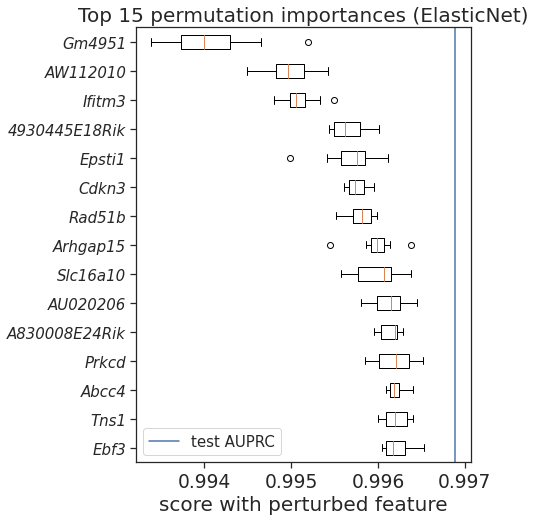

In [60]:
y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
test_score = auc(recall, precision)

sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]

top15 = sorted_indcs[-15:]

plt.figure(figsize=(6, 8))
plt.boxplot(scores[top15].T, labels=np.array(ftr_names)[top15],vert=False)
# plt.axhline(y= 15.4, color='r', label='above the line: postive features, below: negative')
plt.axvline(test_score, label='test AUPRC')
plt.title("Top 15 permutation importances (ElasticNet)", fontsize=20)
plt.xlabel('score with perturbed feature', fontsize=20)
# plt.xlim(0.95, 0.97)
plt.yticks(fontsize=15)
plt.yticks(np.arange(1, 16), np.array(ftr_names)[top15], style='italic', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig('../figures/3_eln_permutation_importance_top15.pdf', bbox_inches='tight')
plt.show()